<a href="https://colab.research.google.com/github/dvncrtr/AIML_Bootcamp_08222/blob/main/Fashion_MNIST_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Competition!
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Classify images from the "Fashion MNIST" data set.   Optimize the test accuracy.

## Metrics

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:![alt text](https://user-images.githubusercontent.com/26015273/41822460-2ca0a90a-77f0-11e8-9c71-7e88fa6b5c61.gif)


The double sum is over the observations `i`, whose number is `N`, and the categories `c`, whose number is `C`. The term `1_{y_i \in C_c}` is the indicator function of the `i`th observation belonging to the `c`th category. The `p_{model}[y_i \in C_c]` is the probability predicted by the model for the `i`th observation to belong to the `c`th category. When there are more than two categories, the neural network outputs a vector of `C` probabilities, each giving the probability that the network input should be classified as belonging to the respective category. When the number of categories is just two, the neural network outputs a single probability `\hat{y}_i`, with the other one being `1` minus the output. This is why the binary cross entropy looks a bit different from categorical cross entropy, despite being a special case of it.

## Dataset

This dataset is the Fashion MNIST dataset

Recently, the researchers at Zalando, an e-commerce company, introduced Fashion MNIST as a drop-in replacement for the original MNIST dataset. Like MNIST, Fashion MNIST consists of a training set consisting of 60,000 examples belonging to 10 different classes and a test set of 10,000 examples. Each training example is a gray-scale image, 28x28 in size. The authors of the work further claim that the Fashion MNIST should actually replace MNIST dataset for benchmarking of new Machine Learning or Computer Vision models.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

The Labels are:  
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

## Objective

In this competition, you can try different variations of the CNN model given as a reference, you may evaluate techniques to squeeze more performance out of a CNN, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be the accuracy of prediction on the test data.  Ties will be broken by Precision accuracy first, then Recall Accuracy if needed.

The results will be revealed at the end of the last day of class.  Please submit your Metrics blocks (Starts with SUBMIT... and ends with END SUBMISSION) to instructors (wtnewman@raytheon.com) before lunch.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.


In [41]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

## Set Up Variables

In [22]:
epochs = 300                 # Number of Training Epochs
num_classes = 10            # This is the number of classes in the Fashion MNIST dataset
batch_size = 2500            # This parameter can be adjusted
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

## Gather and Process Fashion MNIST data

1. First, collect the data from Keras (our goal is someday that our organizational data is this easy to get!)
2. Then split into train and test sets.
3. Next we need to process the data into the proper shape for the CNN
4. Then scale the floats to land between 0 and 1.  Often times we use sklearn's MinMaxScaler for this, but in this case we're going for simplicity.
5. Next take the y_train and y_test labels and encode them one-hot.  This will enable the CNN to function.

In [23]:
# Grab the data from the keras repository

mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)

# Process the date into the right tensor shape.  This is a good practice, but
# usually tensorflow uses channels last (the 'else' here)

if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
#
#  Cast to a 32 bit float and then scale so the value is a float between 0 and 1
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

#
# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

#
# Function to decode one-hot encoding later on when we want to evaluate performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes

'''

Below we're experimenting with the Keras ImageDataGenerator.  From my experience, if these parameters
are set too aggressively, the loss/accuracy will either never improve or it will take too long to improve.
Below is an example of a complex data augmentation regime.  This is just for reference.  See my more simple
one at the bottom.

    
datagen = ImageDataGenerator(rotation_range=0.5, 
                                 zoom_range=0.1,
                                 featurewise_center=True,
                                 #featurewise_std_normalization=True,
                                 width_shift_range=0.1, 
                                 height_shift_range=0.1, 
                                 shear_range=0.1,
                                 horizontal_flip=True, 
                                 fill_mode="nearest")
'''
#
#  Set up our Image Augmentation Data Generator
#
#datagen = ImageDataGenerator(rotation_range=5)
#datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')
datagen.fit(x_train)

(19800, 10)


## Build the Model

* In this example, we define the below block as a Sequential Model. 
* See the excellent [Keras Documentation](https://keras.io/guides/sequential_model/) on Sequential Models for info.
* Many of these parameters can be experimented with.  The documentation will help you understand how much to experiment.

In [34]:
#
# This is what is known as a Tensorflow (Keras) Sequential model
# We will talk at some level about each of these layer types in class.
#
model = Sequential()

model.add(Conv2D(128, kernel_size=(3,3), input_shape=input_shape))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))  
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

my_callbacks = [ModelCheckpoint('model_out.hdf5', monitor='acc', save_best_only=True, period=1)]


## Fit and Evaluate the Model

In [35]:
# Flag to determine whether we use Keras' Image augmentation data generator
augmentation = True

#
# Compile the model so we can fit it. Researching loss functions and optimizers
# might be a good thing to do.
#
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adadelta(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

if not augmentation:
    #
    # Fit the model.  Once the model is trained we'll evaluate the performance.
    print('not using image augmentation')
    hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)
else:
# fits the model on batches with real-time data augmentation:
    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch=len(x_train) / batch_size, validation_data=(x_test, y_test),
                           epochs=epochs, verbose=1, callbacks=my_callbacks, workers = 2)


score = model.evaluate(x_test, y_test)

#
# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print("\nSUBMIT THIS BLOCK for the Competition\n")
print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])
print("END SUBMISSION BLOCK\n")

model.summary()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/300
17/16 [===============================] - ETA: 0s - loss: 2.3012 - accuracy: 0.1181 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.3012 - accuracy: 0.1181 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2992 - val_accuracy: 0.1687 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/300
17/16 [===============================] - ETA: 0s - loss: 2.2999 - accuracy: 0.1183 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.2999 - accuracy: 0.1183 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2975 - val_accuracy: 0.1684 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 3/300
17/16 [===============================] - ETA: 0s - loss: 2.2983 - accuracy: 0.1165 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2983 - accuracy: 0.1165 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2958 - val_accuracy: 0.1672 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 4/300
17/16 [===============================] - ETA: 0s - loss: 2.2970 - accuracy: 0.1180 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2970 - accuracy: 0.1180 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2942 - val_accuracy: 0.1670 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 5/300
17/16 [===============================] - ETA: 0s - loss: 2.2955 - accuracy: 0.1188 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2955 - accuracy: 0.1188 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2925 - val_accuracy: 0.1662 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 6/300
17/16 [===============================] - ETA: 0s - loss: 2.2945 - accuracy: 0.1193 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2945 - accuracy: 0.1193 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2909 - val_accuracy: 0.1651 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 7/300
17/16 [===============================] - ETA: 0s - loss: 2.2932 - accuracy: 0.1216 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2932 - accuracy: 0.1216 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2893 - val_accuracy: 0.1640 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 8/300
17/16 [===============================] - ETA: 0s - loss: 2.2916 - accuracy: 0.1218 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2916 - accuracy: 0.1218 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2877 - val_accuracy: 0.1637 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 9/300
17/16 [===============================] - ETA: 0s - loss: 2.2906 - accuracy: 0.1207 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2906 - accuracy: 0.1207 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2861 - val_accuracy: 0.1633 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 10/300
17/16 [===============================] - ETA: 0s - loss: 2.2897 - accuracy: 0.1204 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2897 - accuracy: 0.1204 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2845 - val_accuracy: 0.1624 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 11/300
17/16 [===============================] - ETA: 0s - loss: 2.2880 - accuracy: 0.1198 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2880 - accuracy: 0.1198 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2829 - val_accuracy: 0.1612 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 12/300
16/16 [============================>.] - ETA: 0s - loss: 2.2866 - accuracy: 0.1230 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2866 - accuracy: 0.1229 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2813 - val_accuracy: 0.1615 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 13/300
17/16 [===============================] - ETA: 0s - loss: 2.2853 - accuracy: 0.1197 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2853 - accuracy: 0.1197 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2798 - val_accuracy: 0.1619 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 14/300
17/16 [===============================] - ETA: 0s - loss: 2.2846 - accuracy: 0.1225 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 21s 1s/step - loss: 2.2846 - accuracy: 0.1225 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2782 - val_accuracy: 0.1604 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 15/300
17/16 [===============================] - ETA: 0s - loss: 2.2824 - accuracy: 0.1225 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 25s 1s/step - loss: 2.2824 - accuracy: 0.1225 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2766 - val_accuracy: 0.1596 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 16/300
17/16 [===============================] - ETA: 0s - loss: 2.2819 - accuracy: 0.1251 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 24s 1s/step - loss: 2.2819 - accuracy: 0.1251 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2750 - val_accuracy: 0.1594 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 17/300
17/16 [===============================] - ETA: 0s - loss: 2.2814 - accuracy: 0.1228 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.2814 - accuracy: 0.1228 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2735 - val_accuracy: 0.1580 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 18/300
17/16 [===============================] - ETA: 0s - loss: 2.2792 - accuracy: 0.1263 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2792 - accuracy: 0.1263 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2719 - val_accuracy: 0.1579 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 19/300
17/16 [===============================] - ETA: 0s - loss: 2.2785 - accuracy: 0.1252 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.2785 - accuracy: 0.1252 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2703 - val_accuracy: 0.1587 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 20/300
17/16 [===============================] - ETA: 0s - loss: 2.2771 - accuracy: 0.1291 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2771 - accuracy: 0.1291 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2687 - val_accuracy: 0.1576 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 21/300
17/16 [===============================] - ETA: 0s - loss: 2.2764 - accuracy: 0.1237 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2764 - accuracy: 0.1237 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2671 - val_accuracy: 0.1563 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 22/300
17/16 [===============================] - ETA: 0s - loss: 2.2750 - accuracy: 0.1241 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2750 - accuracy: 0.1241 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2655 - val_accuracy: 0.1554 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 23/300
17/16 [===============================] - ETA: 0s - loss: 2.2748 - accuracy: 0.1259 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.2748 - accuracy: 0.1259 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2639 - val_accuracy: 0.1559 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 24/300
17/16 [===============================] - ETA: 0s - loss: 2.2730 - accuracy: 0.1286 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2730 - accuracy: 0.1286 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2622 - val_accuracy: 0.1555 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 25/300
17/16 [===============================] - ETA: 0s - loss: 2.2721 - accuracy: 0.1263 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2721 - accuracy: 0.1263 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2606 - val_accuracy: 0.1551 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 26/300
17/16 [===============================] - ETA: 0s - loss: 2.2708 - accuracy: 0.1287 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2708 - accuracy: 0.1287 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2588 - val_accuracy: 0.1544 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 27/300
17/16 [===============================] - ETA: 0s - loss: 2.2695 - accuracy: 0.1271 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2695 - accuracy: 0.1271 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2571 - val_accuracy: 0.1554 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 28/300
17/16 [===============================] - ETA: 0s - loss: 2.2681 - accuracy: 0.1289 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 21s 1s/step - loss: 2.2681 - accuracy: 0.1289 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2554 - val_accuracy: 0.1553 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 29/300
17/16 [===============================] - ETA: 0s - loss: 2.2676 - accuracy: 0.1281 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2676 - accuracy: 0.1281 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2536 - val_accuracy: 0.1561 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 30/300
17/16 [===============================] - ETA: 0s - loss: 2.2666 - accuracy: 0.1275 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2666 - accuracy: 0.1275 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2519 - val_accuracy: 0.1562 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 31/300
17/16 [===============================] - ETA: 0s - loss: 2.2654 - accuracy: 0.1306 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2654 - accuracy: 0.1306 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2501 - val_accuracy: 0.1566 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 32/300
17/16 [===============================] - ETA: 0s - loss: 2.2640 - accuracy: 0.1317 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2640 - accuracy: 0.1317 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2483 - val_accuracy: 0.1566 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 33/300
17/16 [===============================] - ETA: 0s - loss: 2.2625 - accuracy: 0.1319 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2625 - accuracy: 0.1319 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2465 - val_accuracy: 0.1571 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 34/300
17/16 [===============================] - ETA: 0s - loss: 2.2613 - accuracy: 0.1329 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 21s 1s/step - loss: 2.2613 - accuracy: 0.1329 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2446 - val_accuracy: 0.1575 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 35/300
17/16 [===============================] - ETA: 0s - loss: 2.2600 - accuracy: 0.1317 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2600 - accuracy: 0.1317 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2427 - val_accuracy: 0.1588 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 36/300
17/16 [===============================] - ETA: 0s - loss: 2.2590 - accuracy: 0.1315 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2590 - accuracy: 0.1315 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2408 - val_accuracy: 0.1596 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 37/300
17/16 [===============================] - ETA: 0s - loss: 2.2584 - accuracy: 0.1337 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2584 - accuracy: 0.1337 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2388 - val_accuracy: 0.1605 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 38/300
17/16 [===============================] - ETA: 0s - loss: 2.2566 - accuracy: 0.1359 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2566 - accuracy: 0.1359 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2369 - val_accuracy: 0.1631 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 39/300
17/16 [===============================] - ETA: 0s - loss: 2.2557 - accuracy: 0.1342 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2557 - accuracy: 0.1342 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2350 - val_accuracy: 0.1649 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 40/300
17/16 [===============================] - ETA: 0s - loss: 2.2549 - accuracy: 0.1339 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 21s 1s/step - loss: 2.2549 - accuracy: 0.1339 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2330 - val_accuracy: 0.1663 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 41/300
17/16 [===============================] - ETA: 0s - loss: 2.2534 - accuracy: 0.1352 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2534 - accuracy: 0.1352 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2310 - val_accuracy: 0.1683 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 42/300
17/16 [===============================] - ETA: 0s - loss: 2.2520 - accuracy: 0.1389 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2520 - accuracy: 0.1389 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2289 - val_accuracy: 0.1695 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 43/300
16/16 [============================>.] - ETA: 0s - loss: 2.2504 - accuracy: 0.1349 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2503 - accuracy: 0.1349 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2267 - val_accuracy: 0.1713 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 44/300
17/16 [===============================] - ETA: 0s - loss: 2.2484 - accuracy: 0.1382 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2484 - accuracy: 0.1382 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2246 - val_accuracy: 0.1731 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 45/300
17/16 [===============================] - ETA: 0s - loss: 2.2480 - accuracy: 0.1379 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2480 - accuracy: 0.1379 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2224 - val_accuracy: 0.1747 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 46/300
17/16 [===============================] - ETA: 0s - loss: 2.2468 - accuracy: 0.1364 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2468 - accuracy: 0.1364 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2202 - val_accuracy: 0.1756 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 47/300
16/16 [============================>.] - ETA: 0s - loss: 2.2455 - accuracy: 0.1404 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2455 - accuracy: 0.1403 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2180 - val_accuracy: 0.1767 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 48/300
17/16 [===============================] - ETA: 0s - loss: 2.2446 - accuracy: 0.1379 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.2446 - accuracy: 0.1379 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2157 - val_accuracy: 0.1782 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 49/300
17/16 [===============================] - ETA: 0s - loss: 2.2429 - accuracy: 0.1408 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2429 - accuracy: 0.1408 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2135 - val_accuracy: 0.1799 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 50/300
16/16 [============================>.] - ETA: 0s - loss: 2.2418 - accuracy: 0.1399 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2418 - accuracy: 0.1397 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2111 - val_accuracy: 0.1814 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 51/300
17/16 [===============================] - ETA: 0s - loss: 2.2397 - accuracy: 0.1433 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2397 - accuracy: 0.1433 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2087 - val_accuracy: 0.1836 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 52/300
17/16 [===============================] - ETA: 0s - loss: 2.2386 - accuracy: 0.1426 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2386 - accuracy: 0.1426 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2062 - val_accuracy: 0.1857 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 53/300
17/16 [===============================] - ETA: 0s - loss: 2.2372 - accuracy: 0.1435 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2372 - accuracy: 0.1435 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2037 - val_accuracy: 0.1875 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 54/300
17/16 [===============================] - ETA: 0s - loss: 2.2357 - accuracy: 0.1453 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2357 - accuracy: 0.1453 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.2012 - val_accuracy: 0.1883 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 55/300
17/16 [===============================] - ETA: 0s - loss: 2.2346 - accuracy: 0.1420 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2346 - accuracy: 0.1420 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1987 - val_accuracy: 0.1900 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 56/300
17/16 [===============================] - ETA: 0s - loss: 2.2331 - accuracy: 0.1453 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2331 - accuracy: 0.1453 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1962 - val_accuracy: 0.1914 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 57/300
17/16 [===============================] - ETA: 0s - loss: 2.2311 - accuracy: 0.1461 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2311 - accuracy: 0.1461 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1936 - val_accuracy: 0.1927 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 58/300
17/16 [===============================] - ETA: 0s - loss: 2.2304 - accuracy: 0.1447 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2304 - accuracy: 0.1447 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1910 - val_accuracy: 0.1935 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 59/300
17/16 [===============================] - ETA: 0s - loss: 2.2283 - accuracy: 0.1492 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2283 - accuracy: 0.1492 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1884 - val_accuracy: 0.1946 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 60/300
17/16 [===============================] - ETA: 0s - loss: 2.2269 - accuracy: 0.1493 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2269 - accuracy: 0.1493 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1857 - val_accuracy: 0.1965 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 61/300
17/16 [===============================] - ETA: 0s - loss: 2.2255 - accuracy: 0.1486 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2255 - accuracy: 0.1486 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1829 - val_accuracy: 0.1974 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 62/300
16/16 [============================>.] - ETA: 0s - loss: 2.2250 - accuracy: 0.1472 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2251 - accuracy: 0.1469 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1802 - val_accuracy: 0.1981 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 63/300
17/16 [===============================] - ETA: 0s - loss: 2.2220 - accuracy: 0.1498 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 24s 1s/step - loss: 2.2220 - accuracy: 0.1498 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1773 - val_accuracy: 0.2000 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 64/300
17/16 [===============================] - ETA: 0s - loss: 2.2203 - accuracy: 0.1513 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.2203 - accuracy: 0.1513 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1744 - val_accuracy: 0.2022 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 65/300
17/16 [===============================] - ETA: 0s - loss: 2.2179 - accuracy: 0.1520 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2179 - accuracy: 0.1520 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1714 - val_accuracy: 0.2036 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 66/300
17/16 [===============================] - ETA: 0s - loss: 2.2184 - accuracy: 0.1516 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2184 - accuracy: 0.1516 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1685 - val_accuracy: 0.2064 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 67/300
17/16 [===============================] - ETA: 0s - loss: 2.2173 - accuracy: 0.1505 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2173 - accuracy: 0.1505 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1655 - val_accuracy: 0.2072 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 68/300
17/16 [===============================] - ETA: 0s - loss: 2.2147 - accuracy: 0.1564 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2147 - accuracy: 0.1564 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1625 - val_accuracy: 0.2112 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 69/300
17/16 [===============================] - ETA: 0s - loss: 2.2134 - accuracy: 0.1560 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2134 - accuracy: 0.1560 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1594 - val_accuracy: 0.2136 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 70/300
17/16 [===============================] - ETA: 0s - loss: 2.2110 - accuracy: 0.1542 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2110 - accuracy: 0.1542 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1561 - val_accuracy: 0.2141 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 71/300
17/16 [===============================] - ETA: 0s - loss: 2.2101 - accuracy: 0.1553 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2101 - accuracy: 0.1553 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1528 - val_accuracy: 0.2169 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 72/300
17/16 [===============================] - ETA: 0s - loss: 2.2079 - accuracy: 0.1567 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2079 - accuracy: 0.1567 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1496 - val_accuracy: 0.2194 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 73/300
17/16 [===============================] - ETA: 0s - loss: 2.2067 - accuracy: 0.1573 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.2067 - accuracy: 0.1573 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1463 - val_accuracy: 0.2243 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 74/300
17/16 [===============================] - ETA: 0s - loss: 2.2039 - accuracy: 0.1574 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.2039 - accuracy: 0.1574 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1430 - val_accuracy: 0.2275 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 75/300
17/16 [===============================] - ETA: 0s - loss: 2.2023 - accuracy: 0.1609 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 21s 1s/step - loss: 2.2023 - accuracy: 0.1609 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1397 - val_accuracy: 0.2324 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 76/300
17/16 [===============================] - ETA: 0s - loss: 2.2012 - accuracy: 0.1610 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.2012 - accuracy: 0.1610 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1362 - val_accuracy: 0.2373 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 77/300
17/16 [===============================] - ETA: 0s - loss: 2.1986 - accuracy: 0.1617 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.1986 - accuracy: 0.1617 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1327 - val_accuracy: 0.2434 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 78/300
17/16 [===============================] - ETA: 0s - loss: 2.1975 - accuracy: 0.1619 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1975 - accuracy: 0.1619 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1292 - val_accuracy: 0.2509 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 79/300
17/16 [===============================] - ETA: 0s - loss: 2.1946 - accuracy: 0.1660 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1946 - accuracy: 0.1660 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1256 - val_accuracy: 0.2586 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 80/300
17/16 [===============================] - ETA: 0s - loss: 2.1925 - accuracy: 0.1646 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 21s 1s/step - loss: 2.1925 - accuracy: 0.1646 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1219 - val_accuracy: 0.2656 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 81/300
17/16 [===============================] - ETA: 0s - loss: 2.1906 - accuracy: 0.1684 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1906 - accuracy: 0.1684 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1182 - val_accuracy: 0.2712 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 82/300
16/16 [============================>.] - ETA: 0s - loss: 2.1872 - accuracy: 0.1698 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1872 - accuracy: 0.1697 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1143 - val_accuracy: 0.2794 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 83/300
17/16 [===============================] - ETA: 0s - loss: 2.1880 - accuracy: 0.1703 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1880 - accuracy: 0.1703 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1105 - val_accuracy: 0.2879 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 84/300
17/16 [===============================] - ETA: 0s - loss: 2.1861 - accuracy: 0.1724 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1861 - accuracy: 0.1724 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1065 - val_accuracy: 0.2946 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 85/300
17/16 [===============================] - ETA: 0s - loss: 2.1831 - accuracy: 0.1720 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1831 - accuracy: 0.1720 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.1025 - val_accuracy: 0.3047 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 86/300
17/16 [===============================] - ETA: 0s - loss: 2.1801 - accuracy: 0.1750 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1801 - accuracy: 0.1750 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0985 - val_accuracy: 0.3126 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 87/300
17/16 [===============================] - ETA: 0s - loss: 2.1787 - accuracy: 0.1756 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.1787 - accuracy: 0.1756 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0944 - val_accuracy: 0.3182 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 88/300
17/16 [===============================] - ETA: 0s - loss: 2.1773 - accuracy: 0.1778 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1773 - accuracy: 0.1778 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0903 - val_accuracy: 0.3218 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 89/300
17/16 [===============================] - ETA: 0s - loss: 2.1744 - accuracy: 0.1769 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.1744 - accuracy: 0.1769 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0863 - val_accuracy: 0.3299 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 90/300
17/16 [===============================] - ETA: 0s - loss: 2.1722 - accuracy: 0.1808 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1722 - accuracy: 0.1808 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0820 - val_accuracy: 0.3365 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 91/300
17/16 [===============================] - ETA: 0s - loss: 2.1693 - accuracy: 0.1819 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1693 - accuracy: 0.1819 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0778 - val_accuracy: 0.3414 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 92/300
17/16 [===============================] - ETA: 0s - loss: 2.1676 - accuracy: 0.1847 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1676 - accuracy: 0.1847 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0735 - val_accuracy: 0.3481 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 93/300
16/16 [============================>.] - ETA: 0s - loss: 2.1643 - accuracy: 0.1860 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1644 - accuracy: 0.1858 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0691 - val_accuracy: 0.3539 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 94/300
17/16 [===============================] - ETA: 0s - loss: 2.1633 - accuracy: 0.1855 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1633 - accuracy: 0.1855 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0648 - val_accuracy: 0.3579 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 95/300
17/16 [===============================] - ETA: 0s - loss: 2.1604 - accuracy: 0.1868 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 20s 1s/step - loss: 2.1604 - accuracy: 0.1868 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0603 - val_accuracy: 0.3618 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 96/300
17/16 [===============================] - ETA: 0s - loss: 2.1585 - accuracy: 0.1864 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1585 - accuracy: 0.1864 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0559 - val_accuracy: 0.3674 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 97/300
17/16 [===============================] - ETA: -1s - loss: 2.1551 - accuracy: 0.1936 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1551 - accuracy: 0.1936 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0513 - val_accuracy: 0.3712 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 98/300
17/16 [===============================] - ETA: 0s - loss: 2.1534 - accuracy: 0.1943 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1534 - accuracy: 0.1943 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0467 - val_accuracy: 0.3766 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 99/300
17/16 [===============================] - ETA: 0s - loss: 2.1514 - accuracy: 0.1942 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1514 - accuracy: 0.1942 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0420 - val_accuracy: 0.3798 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 100/300
17/16 [===============================] - ETA: -1s - loss: 2.1487 - accuracy: 0.1958 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1487 - accuracy: 0.1958 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0373 - val_accuracy: 0.3841 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 101/300
16/16 [============================>.] - ETA: 0s - loss: 2.1472 - accuracy: 0.1980 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1472 - accuracy: 0.1979 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0325 - val_accuracy: 0.3877 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 102/300
17/16 [===============================] - ETA: 0s - loss: 2.1446 - accuracy: 0.1985 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 24s 1s/step - loss: 2.1446 - accuracy: 0.1985 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0278 - val_accuracy: 0.3908 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 103/300
17/16 [===============================] - ETA: 0s - loss: 2.1420 - accuracy: 0.2003 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1420 - accuracy: 0.2003 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0230 - val_accuracy: 0.3927 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 104/300
17/16 [===============================] - ETA: 0s - loss: 2.1407 - accuracy: 0.2008 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1407 - accuracy: 0.2008 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0181 - val_accuracy: 0.3959 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 105/300
17/16 [===============================] - ETA: 0s - loss: 2.1379 - accuracy: 0.2016 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1379 - accuracy: 0.2016 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0131 - val_accuracy: 0.3996 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 106/300
17/16 [===============================] - ETA: 0s - loss: 2.1368 - accuracy: 0.2033 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1368 - accuracy: 0.2033 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0084 - val_accuracy: 0.4022 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 107/300
17/16 [===============================] - ETA: 0s - loss: 2.1328 - accuracy: 0.2042 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1328 - accuracy: 0.2042 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 2.0035 - val_accuracy: 0.4012 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 108/300
17/16 [===============================] - ETA: 0s - loss: 2.1297 - accuracy: 0.2092 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 24s 1s/step - loss: 2.1297 - accuracy: 0.2092 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 1.9984 - val_accuracy: 0.4037 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 109/300
17/16 [===============================] - ETA: 0s - loss: 2.1279 - accuracy: 0.2079 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 21s 1s/step - loss: 2.1279 - accuracy: 0.2079 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 1.9934 - val_accuracy: 0.4039 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 110/300
17/16 [===============================] - ETA: 0s - loss: 2.1255 - accuracy: 0.2130 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1255 - accuracy: 0.2130 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 1.9882 - val_accuracy: 0.4056 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 111/300
17/16 [===============================] - ETA: 0s - loss: 2.1226 - accuracy: 0.2121 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1226 - accuracy: 0.2121 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 1.9831 - val_accuracy: 0.4075 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 112/300
17/16 [===============================] - ETA: 0s - loss: 2.1181 - accuracy: 0.2154 - precision_9: 1.0000 - recall_9: 2.4876e-05

16/16 [==============================] - 23s 1s/step - loss: 2.1181 - accuracy: 0.2154 - precision_9: 1.0000 - recall_9: 2.4876e-05 - val_loss: 1.9779 - val_accuracy: 0.4092 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 113/300
17/16 [===============================] - ETA: 0s - loss: 2.1177 - accuracy: 0.2148 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 22s 1s/step - loss: 2.1177 - accuracy: 0.2148 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 1.9728 - val_accuracy: 0.4102 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 114/300
17/16 [===============================] - ETA: 0s - loss: 2.1140 - accuracy: 0.2169 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

16/16 [==============================] - 23s 1s/step - loss: 2.1140 - accuracy: 0.2169 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_loss: 1.9676 - val_accuracy: 0.4098 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 115/300
17/16 [===============================] - ETA: 0s - loss: 2.1119 - accuracy: 0.2199 - precision_9: 1.0000 - recall_9: 2.4876e-05

16/16 [==============================] - 23s 1s/step - loss: 2.1119 - accuracy: 0.2199 - precision_9: 1.0000 - recall_9: 2.4876e-05 - val_loss: 1.9623 - val_accuracy: 0.4105 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 116/300
17/16 [===============================] - ETA: 0s - loss: 2.1097 - accuracy: 0.2211 - precision_9: 1.0000 - recall_9: 2.4876e-05

16/16 [==============================] - 21s 1s/step - loss: 2.1097 - accuracy: 0.2211 - precision_9: 1.0000 - recall_9: 2.4876e-05 - val_loss: 1.9571 - val_accuracy: 0.4116 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 117/300
17/16 [===============================] - ETA: 0s - loss: 2.1036 - accuracy: 0.2265 - precision_9: 1.0000 - recall_9: 2.4876e-05

16/16 [==============================] - 23s 1s/step - loss: 2.1036 - accuracy: 0.2265 - precision_9: 1.0000 - recall_9: 2.4876e-05 - val_loss: 1.9517 - val_accuracy: 0.4114 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 118/300
17/16 [===============================] - ETA: 0s - loss: 2.1047 - accuracy: 0.2246 - precision_9: 1.0000 - recall_9: 2.4876e-05

16/16 [==============================] - 23s 1s/step - loss: 2.1047 - accuracy: 0.2246 - precision_9: 1.0000 - recall_9: 2.4876e-05 - val_loss: 1.9464 - val_accuracy: 0.4115 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 119/300
17/16 [===============================] - ETA: 0s - loss: 2.1018 - accuracy: 0.2227 - precision_9: 1.0000 - recall_9: 4.9751e-05

16/16 [==============================] - 21s 1s/step - loss: 2.1018 - accuracy: 0.2227 - precision_9: 1.0000 - recall_9: 4.9751e-05 - val_loss: 1.9411 - val_accuracy: 0.4116 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 120/300
17/16 [===============================] - ETA: 0s - loss: 2.0978 - accuracy: 0.2305 - precision_9: 0.6667 - recall_9: 4.9751e-05

16/16 [==============================] - 23s 1s/step - loss: 2.0978 - accuracy: 0.2305 - precision_9: 0.6667 - recall_9: 4.9751e-05 - val_loss: 1.9357 - val_accuracy: 0.4112 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 121/300
17/16 [===============================] - ETA: 0s - loss: 2.0953 - accuracy: 0.2282 - precision_9: 1.0000 - recall_9: 4.9751e-05

16/16 [==============================] - 24s 1s/step - loss: 2.0953 - accuracy: 0.2282 - precision_9: 1.0000 - recall_9: 4.9751e-05 - val_loss: 1.9303 - val_accuracy: 0.4125 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 122/300
17/16 [===============================] - ETA: 0s - loss: 2.0947 - accuracy: 0.2298 - precision_9: 0.6000 - recall_9: 7.4627e-05

16/16 [==============================] - 21s 1s/step - loss: 2.0947 - accuracy: 0.2298 - precision_9: 0.6000 - recall_9: 7.4627e-05 - val_loss: 1.9249 - val_accuracy: 0.4133 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 123/300
17/16 [===============================] - ETA: 0s - loss: 2.0901 - accuracy: 0.2335 - precision_9: 1.0000 - recall_9: 4.9751e-05

16/16 [==============================] - 23s 1s/step - loss: 2.0901 - accuracy: 0.2335 - precision_9: 1.0000 - recall_9: 4.9751e-05 - val_loss: 1.9195 - val_accuracy: 0.4142 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 124/300
17/16 [===============================] - ETA: 0s - loss: 2.0893 - accuracy: 0.2330 - precision_9: 0.8571 - recall_9: 1.4925e-04

16/16 [==============================] - 21s 1s/step - loss: 2.0893 - accuracy: 0.2330 - precision_9: 0.8571 - recall_9: 1.4925e-04 - val_loss: 1.9142 - val_accuracy: 0.4133 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 125/300
17/16 [===============================] - ETA: 0s - loss: 2.0842 - accuracy: 0.2329 - precision_9: 0.8333 - recall_9: 1.2438e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0842 - accuracy: 0.2329 - precision_9: 0.8333 - recall_9: 1.2438e-04 - val_loss: 1.9088 - val_accuracy: 0.4122 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 126/300
17/16 [===============================] - ETA: 0s - loss: 2.0829 - accuracy: 0.2330 - precision_9: 1.0000 - recall_9: 1.2438e-04

16/16 [==============================] - 22s 1s/step - loss: 2.0829 - accuracy: 0.2330 - precision_9: 1.0000 - recall_9: 1.2438e-04 - val_loss: 1.9033 - val_accuracy: 0.4129 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 127/300
17/16 [===============================] - ETA: 0s - loss: 2.0812 - accuracy: 0.2333 - precision_9: 0.7500 - recall_9: 7.4627e-05

16/16 [==============================] - 23s 1s/step - loss: 2.0812 - accuracy: 0.2333 - precision_9: 0.7500 - recall_9: 7.4627e-05 - val_loss: 1.8980 - val_accuracy: 0.4129 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 128/300
17/16 [===============================] - ETA: 0s - loss: 2.0776 - accuracy: 0.2374 - precision_9: 0.8333 - recall_9: 1.2438e-04

16/16 [==============================] - 22s 1s/step - loss: 2.0776 - accuracy: 0.2374 - precision_9: 0.8333 - recall_9: 1.2438e-04 - val_loss: 1.8925 - val_accuracy: 0.4148 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 129/300
17/16 [===============================] - ETA: 0s - loss: 2.0749 - accuracy: 0.2405 - precision_9: 0.8333 - recall_9: 1.2438e-04

16/16 [==============================] - 22s 1s/step - loss: 2.0749 - accuracy: 0.2405 - precision_9: 0.8333 - recall_9: 1.2438e-04 - val_loss: 1.8870 - val_accuracy: 0.4148 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 130/300
17/16 [===============================] - ETA: 0s - loss: 2.0703 - accuracy: 0.2409 - precision_9: 1.0000 - recall_9: 1.7413e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0703 - accuracy: 0.2409 - precision_9: 1.0000 - recall_9: 1.7413e-04 - val_loss: 1.8814 - val_accuracy: 0.4157 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 131/300
17/16 [===============================] - ETA: 0s - loss: 2.0662 - accuracy: 0.2423 - precision_9: 1.0000 - recall_9: 1.2438e-04

16/16 [==============================] - 21s 1s/step - loss: 2.0662 - accuracy: 0.2423 - precision_9: 1.0000 - recall_9: 1.2438e-04 - val_loss: 1.8757 - val_accuracy: 0.4172 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 132/300
16/16 [============================>.] - ETA: 0s - loss: 2.0690 - accuracy: 0.2444 - precision_9: 0.7500 - recall_9: 2.2500e-04

16/16 [==============================] - 22s 1s/step - loss: 2.0689 - accuracy: 0.2444 - precision_9: 0.7500 - recall_9: 2.2388e-04 - val_loss: 1.8706 - val_accuracy: 0.4169 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 133/300
17/16 [===============================] - ETA: 0s - loss: 2.0628 - accuracy: 0.2429 - precision_9: 0.8889 - recall_9: 1.9900e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0628 - accuracy: 0.2429 - precision_9: 0.8889 - recall_9: 1.9900e-04 - val_loss: 1.8652 - val_accuracy: 0.4159 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 134/300
17/16 [===============================] - ETA: 0s - loss: 2.0621 - accuracy: 0.2448 - precision_9: 0.9412 - recall_9: 3.9801e-04

16/16 [==============================] - 22s 1s/step - loss: 2.0621 - accuracy: 0.2448 - precision_9: 0.9412 - recall_9: 3.9801e-04 - val_loss: 1.8598 - val_accuracy: 0.4177 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 135/300
17/16 [===============================] - ETA: -1s - loss: 2.0587 - accuracy: 0.2468 - precision_9: 0.9286 - recall_9: 3.2338e-04

16/16 [==============================] - 22s 1s/step - loss: 2.0587 - accuracy: 0.2468 - precision_9: 0.9286 - recall_9: 3.2338e-04 - val_loss: 1.8545 - val_accuracy: 0.4182 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 136/300
17/16 [===============================] - ETA: 0s - loss: 2.0540 - accuracy: 0.2475 - precision_9: 0.7917 - recall_9: 4.7264e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0540 - accuracy: 0.2475 - precision_9: 0.7917 - recall_9: 4.7264e-04 - val_loss: 1.8489 - val_accuracy: 0.4193 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 137/300
17/16 [===============================] - ETA: 0s - loss: 2.0570 - accuracy: 0.2445 - precision_9: 0.9130 - recall_9: 5.2239e-04

16/16 [==============================] - 24s 1s/step - loss: 2.0570 - accuracy: 0.2445 - precision_9: 0.9130 - recall_9: 5.2239e-04 - val_loss: 1.8438 - val_accuracy: 0.4205 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 138/300
17/16 [===============================] - ETA: 0s - loss: 2.0526 - accuracy: 0.2490 - precision_9: 0.6667 - recall_9: 2.4876e-04

16/16 [==============================] - 21s 1s/step - loss: 2.0526 - accuracy: 0.2490 - precision_9: 0.6667 - recall_9: 2.4876e-04 - val_loss: 1.8385 - val_accuracy: 0.4205 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 139/300
17/16 [===============================] - ETA: 0s - loss: 2.0490 - accuracy: 0.2492 - precision_9: 0.8077 - recall_9: 5.2239e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0490 - accuracy: 0.2492 - precision_9: 0.8077 - recall_9: 5.2239e-04 - val_loss: 1.8332 - val_accuracy: 0.4206 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 140/300
17/16 [===============================] - ETA: 0s - loss: 2.0495 - accuracy: 0.2477 - precision_9: 0.8065 - recall_9: 6.2189e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0495 - accuracy: 0.2477 - precision_9: 0.8065 - recall_9: 6.2189e-04 - val_loss: 1.8282 - val_accuracy: 0.4225 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 141/300
16/16 [============================>.] - ETA: 0s - loss: 2.0452 - accuracy: 0.2503 - precision_9: 0.7308 - recall_9: 4.7500e-04

16/16 [==============================] - 24s 1s/step - loss: 2.0451 - accuracy: 0.2504 - precision_9: 0.7308 - recall_9: 4.7264e-04 - val_loss: 1.8231 - val_accuracy: 0.4216 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 142/300
17/16 [===============================] - ETA: 0s - loss: 2.0400 - accuracy: 0.2555 - precision_9: 0.8889 - recall_9: 5.9701e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0400 - accuracy: 0.2555 - precision_9: 0.8889 - recall_9: 5.9701e-04 - val_loss: 1.8178 - val_accuracy: 0.4228 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 143/300
17/16 [===============================] - ETA: 0s - loss: 2.0400 - accuracy: 0.2511 - precision_9: 0.7222 - recall_9: 6.4677e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0400 - accuracy: 0.2511 - precision_9: 0.7222 - recall_9: 6.4677e-04 - val_loss: 1.8126 - val_accuracy: 0.4248 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 144/300
17/16 [===============================] - ETA: 0s - loss: 2.0337 - accuracy: 0.2569 - precision_9: 0.7105 - recall_9: 6.7164e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0337 - accuracy: 0.2569 - precision_9: 0.7105 - recall_9: 6.7164e-04 - val_loss: 1.8071 - val_accuracy: 0.4250 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 145/300
17/16 [===============================] - ETA: 0s - loss: 2.0336 - accuracy: 0.2535 - precision_9: 0.7234 - recall_9: 8.4577e-04

16/16 [==============================] - 22s 1s/step - loss: 2.0336 - accuracy: 0.2535 - precision_9: 0.7234 - recall_9: 8.4577e-04 - val_loss: 1.8021 - val_accuracy: 0.4262 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 146/300
17/16 [===============================] - ETA: 0s - loss: 2.0322 - accuracy: 0.2551 - precision_9: 0.7143 - recall_9: 8.7065e-04

16/16 [==============================] - 24s 1s/step - loss: 2.0322 - accuracy: 0.2551 - precision_9: 0.7143 - recall_9: 8.7065e-04 - val_loss: 1.7968 - val_accuracy: 0.4275 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 147/300
17/16 [===============================] - ETA: 0s - loss: 2.0331 - accuracy: 0.2559 - precision_9: 0.7391 - recall_9: 8.4577e-04

16/16 [==============================] - 22s 1s/step - loss: 2.0331 - accuracy: 0.2559 - precision_9: 0.7391 - recall_9: 8.4577e-04 - val_loss: 1.7918 - val_accuracy: 0.4289 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 148/300
17/16 [===============================] - ETA: 0s - loss: 2.0268 - accuracy: 0.2571 - precision_9: 0.7083 - recall_9: 8.4577e-04

16/16 [==============================] - 23s 1s/step - loss: 2.0268 - accuracy: 0.2571 - precision_9: 0.7083 - recall_9: 8.4577e-04 - val_loss: 1.7869 - val_accuracy: 0.4292 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 149/300
17/16 [===============================] - ETA: 0s - loss: 2.0256 - accuracy: 0.2602 - precision_9: 0.8070 - recall_9: 0.0011

16/16 [==============================] - 23s 1s/step - loss: 2.0256 - accuracy: 0.2602 - precision_9: 0.8070 - recall_9: 0.0011 - val_loss: 1.7817 - val_accuracy: 0.4328 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 150/300
17/16 [===============================] - ETA: 0s - loss: 2.0206 - accuracy: 0.2607 - precision_9: 0.7679 - recall_9: 0.0011

16/16 [==============================] - 23s 1s/step - loss: 2.0206 - accuracy: 0.2607 - precision_9: 0.7679 - recall_9: 0.0011 - val_loss: 1.7764 - val_accuracy: 0.4340 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 151/300
17/16 [===============================] - ETA: 0s - loss: 2.0199 - accuracy: 0.2598 - precision_9: 0.7500 - recall_9: 0.0011

16/16 [==============================] - 23s 1s/step - loss: 2.0199 - accuracy: 0.2598 - precision_9: 0.7500 - recall_9: 0.0011 - val_loss: 1.7717 - val_accuracy: 0.4344 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 152/300
17/16 [===============================] - ETA: 0s - loss: 2.0162 - accuracy: 0.2614 - precision_9: 0.7353 - recall_9: 0.0012

16/16 [==============================] - 22s 1s/step - loss: 2.0162 - accuracy: 0.2614 - precision_9: 0.7353 - recall_9: 0.0012 - val_loss: 1.7667 - val_accuracy: 0.4354 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 153/300
17/16 [===============================] - ETA: 0s - loss: 2.0139 - accuracy: 0.2610 - precision_9: 0.6977 - recall_9: 0.0015

16/16 [==============================] - 23s 1s/step - loss: 2.0139 - accuracy: 0.2610 - precision_9: 0.6977 - recall_9: 0.0015 - val_loss: 1.7615 - val_accuracy: 0.4380 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 154/300
17/16 [===============================] - ETA: 0s - loss: 2.0101 - accuracy: 0.2650 - precision_9: 0.6364 - recall_9: 0.0012

16/16 [==============================] - 24s 1s/step - loss: 2.0101 - accuracy: 0.2650 - precision_9: 0.6364 - recall_9: 0.0012 - val_loss: 1.7568 - val_accuracy: 0.4378 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 155/300
17/16 [===============================] - ETA: 0s - loss: 2.0173 - accuracy: 0.2616 - precision_9: 0.7386 - recall_9: 0.0016

16/16 [==============================] - 23s 1s/step - loss: 2.0173 - accuracy: 0.2616 - precision_9: 0.7386 - recall_9: 0.0016 - val_loss: 1.7523 - val_accuracy: 0.4376 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 156/300
17/16 [===============================] - ETA: 0s - loss: 2.0088 - accuracy: 0.2646 - precision_9: 0.7234 - recall_9: 0.0017

16/16 [==============================] - 22s 1s/step - loss: 2.0088 - accuracy: 0.2646 - precision_9: 0.7234 - recall_9: 0.0017 - val_loss: 1.7473 - val_accuracy: 0.4401 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 157/300
16/16 [============================>.] - ETA: 0s - loss: 2.0028 - accuracy: 0.2641 - precision_9: 0.7745 - recall_9: 0.0020

16/16 [==============================] - 21s 1s/step - loss: 2.0027 - accuracy: 0.2641 - precision_9: 0.7745 - recall_9: 0.0020 - val_loss: 1.7428 - val_accuracy: 0.4409 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 158/300
17/16 [===============================] - ETA: 0s - loss: 2.0019 - accuracy: 0.2653 - precision_9: 0.6729 - recall_9: 0.0018

16/16 [==============================] - 23s 1s/step - loss: 2.0019 - accuracy: 0.2653 - precision_9: 0.6729 - recall_9: 0.0018 - val_loss: 1.7384 - val_accuracy: 0.4418 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 159/300
17/16 [===============================] - ETA: 0s - loss: 2.0041 - accuracy: 0.2666 - precision_9: 0.7264 - recall_9: 0.0019

16/16 [==============================] - 22s 1s/step - loss: 2.0041 - accuracy: 0.2666 - precision_9: 0.7264 - recall_9: 0.0019 - val_loss: 1.7338 - val_accuracy: 0.4421 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 160/300
17/16 [===============================] - ETA: 0s - loss: 1.9993 - accuracy: 0.2692 - precision_9: 0.6497 - recall_9: 0.0025

16/16 [==============================] - 23s 1s/step - loss: 1.9993 - accuracy: 0.2692 - precision_9: 0.6497 - recall_9: 0.0025 - val_loss: 1.7293 - val_accuracy: 0.4426 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 161/300
17/16 [===============================] - ETA: 0s - loss: 1.9947 - accuracy: 0.2700 - precision_9: 0.7379 - recall_9: 0.0027

16/16 [==============================] - 24s 1s/step - loss: 1.9947 - accuracy: 0.2700 - precision_9: 0.7379 - recall_9: 0.0027 - val_loss: 1.7246 - val_accuracy: 0.4434 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 162/300
17/16 [===============================] - ETA: 0s - loss: 1.9945 - accuracy: 0.2733 - precision_9: 0.6277 - recall_9: 0.0021

16/16 [==============================] - 22s 1s/step - loss: 1.9945 - accuracy: 0.2733 - precision_9: 0.6277 - recall_9: 0.0021 - val_loss: 1.7203 - val_accuracy: 0.4464 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 163/300
17/16 [===============================] - ETA: 0s - loss: 1.9886 - accuracy: 0.2748 - precision_9: 0.6914 - recall_9: 0.0028

16/16 [==============================] - 21s 1s/step - loss: 1.9886 - accuracy: 0.2748 - precision_9: 0.6914 - recall_9: 0.0028 - val_loss: 1.7160 - val_accuracy: 0.4449 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 164/300
17/16 [===============================] - ETA: 0s - loss: 1.9920 - accuracy: 0.2688 - precision_9: 0.7286 - recall_9: 0.0038

16/16 [==============================] - 22s 1s/step - loss: 1.9920 - accuracy: 0.2688 - precision_9: 0.7286 - recall_9: 0.0038 - val_loss: 1.7117 - val_accuracy: 0.4460 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 165/300
17/16 [===============================] - ETA: 0s - loss: 1.9849 - accuracy: 0.2761 - precision_9: 0.6740 - recall_9: 0.0030

16/16 [==============================] - 23s 1s/step - loss: 1.9849 - accuracy: 0.2761 - precision_9: 0.6740 - recall_9: 0.0030 - val_loss: 1.7070 - val_accuracy: 0.4490 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 166/300
17/16 [===============================] - ETA: 0s - loss: 1.9862 - accuracy: 0.2746 - precision_9: 0.6262 - recall_9: 0.0032

16/16 [==============================] - 21s 1s/step - loss: 1.9862 - accuracy: 0.2746 - precision_9: 0.6262 - recall_9: 0.0032 - val_loss: 1.7028 - val_accuracy: 0.4514 - val_precision_9: 1.0000 - val_recall_9: 5.0505e-05
Epoch 167/300
16/16 [============================>.] - ETA: 0s - loss: 1.9883 - accuracy: 0.2692 - precision_9: 0.6681 - recall_9: 0.0040

16/16 [==============================] - 22s 1s/step - loss: 1.9881 - accuracy: 0.2694 - precision_9: 0.6722 - recall_9: 0.0040 - val_loss: 1.6986 - val_accuracy: 0.4551 - val_precision_9: 1.0000 - val_recall_9: 5.0505e-05
Epoch 168/300
17/16 [===============================] - ETA: -1s - loss: 1.9804 - accuracy: 0.2765 - precision_9: 0.6902 - recall_9: 0.0044

16/16 [==============================] - 23s 1s/step - loss: 1.9804 - accuracy: 0.2765 - precision_9: 0.6902 - recall_9: 0.0044 - val_loss: 1.6942 - val_accuracy: 0.4554 - val_precision_9: 0.5000 - val_recall_9: 5.0505e-05
Epoch 169/300
17/16 [===============================] - ETA: 0s - loss: 1.9806 - accuracy: 0.2755 - precision_9: 0.6213 - recall_9: 0.0036

16/16 [==============================] - 23s 1s/step - loss: 1.9806 - accuracy: 0.2755 - precision_9: 0.6213 - recall_9: 0.0036 - val_loss: 1.6903 - val_accuracy: 0.4562 - val_precision_9: 0.7500 - val_recall_9: 1.5152e-04
Epoch 170/300
17/16 [===============================] - ETA: 0s - loss: 1.9780 - accuracy: 0.2783 - precision_9: 0.6960 - recall_9: 0.0047

16/16 [==============================] - 23s 1s/step - loss: 1.9780 - accuracy: 0.2783 - precision_9: 0.6960 - recall_9: 0.0047 - val_loss: 1.6863 - val_accuracy: 0.4596 - val_precision_9: 0.8000 - val_recall_9: 2.0202e-04
Epoch 171/300
17/16 [===============================] - ETA: 0s - loss: 1.9761 - accuracy: 0.2755 - precision_9: 0.6264 - recall_9: 0.0043

16/16 [==============================] - 21s 1s/step - loss: 1.9761 - accuracy: 0.2755 - precision_9: 0.6264 - recall_9: 0.0043 - val_loss: 1.6822 - val_accuracy: 0.4619 - val_precision_9: 0.7000 - val_recall_9: 3.5354e-04
Epoch 172/300
17/16 [===============================] - ETA: 0s - loss: 1.9748 - accuracy: 0.2774 - precision_9: 0.6601 - recall_9: 0.0050

16/16 [==============================] - 22s 1s/step - loss: 1.9748 - accuracy: 0.2774 - precision_9: 0.6601 - recall_9: 0.0050 - val_loss: 1.6786 - val_accuracy: 0.4617 - val_precision_9: 0.7647 - val_recall_9: 6.5657e-04
Epoch 173/300
17/16 [===============================] - ETA: 0s - loss: 1.9694 - accuracy: 0.2829 - precision_9: 0.6452 - recall_9: 0.0050

16/16 [==============================] - 22s 1s/step - loss: 1.9694 - accuracy: 0.2829 - precision_9: 0.6452 - recall_9: 0.0050 - val_loss: 1.6746 - val_accuracy: 0.4629 - val_precision_9: 0.7143 - val_recall_9: 7.5758e-04
Epoch 174/300
17/16 [===============================] - ETA: 0s - loss: 1.9693 - accuracy: 0.2798 - precision_9: 0.6826 - recall_9: 0.0050

16/16 [==============================] - 22s 1s/step - loss: 1.9693 - accuracy: 0.2798 - precision_9: 0.6826 - recall_9: 0.0050 - val_loss: 1.6708 - val_accuracy: 0.4635 - val_precision_9: 0.7879 - val_recall_9: 0.0013
Epoch 175/300
17/16 [===============================] - ETA: 0s - loss: 1.9687 - accuracy: 0.2773 - precision_9: 0.6303 - recall_9: 0.0052

16/16 [==============================] - 23s 1s/step - loss: 1.9687 - accuracy: 0.2773 - precision_9: 0.6303 - recall_9: 0.0052 - val_loss: 1.6670 - val_accuracy: 0.4667 - val_precision_9: 0.8372 - val_recall_9: 0.0018
Epoch 176/300
17/16 [===============================] - ETA: 0s - loss: 1.9694 - accuracy: 0.2793 - precision_9: 0.6212 - recall_9: 0.0055

16/16 [==============================] - 22s 1s/step - loss: 1.9694 - accuracy: 0.2793 - precision_9: 0.6212 - recall_9: 0.0055 - val_loss: 1.6634 - val_accuracy: 0.4667 - val_precision_9: 0.8400 - val_recall_9: 0.0021
Epoch 177/300
17/16 [===============================] - ETA: -1s - loss: 1.9663 - accuracy: 0.2800 - precision_9: 0.6747 - recall_9: 0.0062

16/16 [==============================] - 23s 1s/step - loss: 1.9663 - accuracy: 0.2800 - precision_9: 0.6747 - recall_9: 0.0062 - val_loss: 1.6597 - val_accuracy: 0.4679 - val_precision_9: 0.8413 - val_recall_9: 0.0027
Epoch 178/300
17/16 [===============================] - ETA: 0s - loss: 1.9612 - accuracy: 0.2800 - precision_9: 0.6512 - recall_9: 0.0059

16/16 [==============================] - 22s 1s/step - loss: 1.9612 - accuracy: 0.2800 - precision_9: 0.6512 - recall_9: 0.0059 - val_loss: 1.6561 - val_accuracy: 0.4676 - val_precision_9: 0.8169 - val_recall_9: 0.0029
Epoch 179/300
17/16 [===============================] - ETA: 0s - loss: 1.9587 - accuracy: 0.2819 - precision_9: 0.6775 - recall_9: 0.0073

16/16 [==============================] - 22s 1s/step - loss: 1.9587 - accuracy: 0.2819 - precision_9: 0.6775 - recall_9: 0.0073 - val_loss: 1.6522 - val_accuracy: 0.4698 - val_precision_9: 0.8526 - val_recall_9: 0.0041
Epoch 180/300
16/16 [============================>.] - ETA: 0s - loss: 1.9594 - accuracy: 0.2791 - precision_9: 0.6224 - recall_9: 0.0067

16/16 [==============================] - 22s 1s/step - loss: 1.9595 - accuracy: 0.2792 - precision_9: 0.6218 - recall_9: 0.0067 - val_loss: 1.6488 - val_accuracy: 0.4715 - val_precision_9: 0.8692 - val_recall_9: 0.0047
Epoch 181/300
17/16 [===============================] - ETA: 0s - loss: 1.9564 - accuracy: 0.2831 - precision_9: 0.6491 - recall_9: 0.0074

16/16 [==============================] - 23s 1s/step - loss: 1.9564 - accuracy: 0.2831 - precision_9: 0.6491 - recall_9: 0.0074 - val_loss: 1.6450 - val_accuracy: 0.4724 - val_precision_9: 0.8595 - val_recall_9: 0.0053
Epoch 182/300
17/16 [===============================] - ETA: 0s - loss: 1.9593 - accuracy: 0.2810 - precision_9: 0.6522 - recall_9: 0.0071

16/16 [==============================] - 22s 1s/step - loss: 1.9593 - accuracy: 0.2810 - precision_9: 0.6522 - recall_9: 0.0071 - val_loss: 1.6416 - val_accuracy: 0.4739 - val_precision_9: 0.8777 - val_recall_9: 0.0062
Epoch 183/300
17/16 [===============================] - ETA: 0s - loss: 1.9541 - accuracy: 0.2810 - precision_9: 0.6145 - recall_9: 0.0078

16/16 [==============================] - 23s 1s/step - loss: 1.9541 - accuracy: 0.2810 - precision_9: 0.6145 - recall_9: 0.0078 - val_loss: 1.6388 - val_accuracy: 0.4737 - val_precision_9: 0.8696 - val_recall_9: 0.0071
Epoch 184/300
17/16 [===============================] - ETA: 0s - loss: 1.9543 - accuracy: 0.2845 - precision_9: 0.6350 - recall_9: 0.0071

16/16 [==============================] - 22s 1s/step - loss: 1.9543 - accuracy: 0.2845 - precision_9: 0.6350 - recall_9: 0.0071 - val_loss: 1.6355 - val_accuracy: 0.4778 - val_precision_9: 0.8715 - val_recall_9: 0.0079
Epoch 185/300
17/16 [===============================] - ETA: 0s - loss: 1.9522 - accuracy: 0.2825 - precision_9: 0.6491 - recall_9: 0.0083

16/16 [==============================] - 21s 1s/step - loss: 1.9522 - accuracy: 0.2825 - precision_9: 0.6491 - recall_9: 0.0083 - val_loss: 1.6324 - val_accuracy: 0.4792 - val_precision_9: 0.8706 - val_recall_9: 0.0088
Epoch 186/300
17/16 [===============================] - ETA: 0s - loss: 1.9446 - accuracy: 0.2860 - precision_9: 0.6462 - recall_9: 0.0086

16/16 [==============================] - 22s 1s/step - loss: 1.9446 - accuracy: 0.2860 - precision_9: 0.6462 - recall_9: 0.0086 - val_loss: 1.6288 - val_accuracy: 0.4810 - val_precision_9: 0.8733 - val_recall_9: 0.0097
Epoch 187/300
17/16 [===============================] - ETA: 0s - loss: 1.9448 - accuracy: 0.2880 - precision_9: 0.6399 - recall_9: 0.0081

16/16 [==============================] - 22s 1s/step - loss: 1.9448 - accuracy: 0.2880 - precision_9: 0.6399 - recall_9: 0.0081 - val_loss: 1.6257 - val_accuracy: 0.4806 - val_precision_9: 0.8794 - val_recall_9: 0.0114
Epoch 188/300
17/16 [===============================] - ETA: 0s - loss: 1.9433 - accuracy: 0.2867 - precision_9: 0.6476 - recall_9: 0.0096

16/16 [==============================] - 23s 1s/step - loss: 1.9433 - accuracy: 0.2867 - precision_9: 0.6476 - recall_9: 0.0096 - val_loss: 1.6227 - val_accuracy: 0.4811 - val_precision_9: 0.8780 - val_recall_9: 0.0127
Epoch 189/300
17/16 [===============================] - ETA: 0s - loss: 1.9440 - accuracy: 0.2855 - precision_9: 0.6361 - recall_9: 0.0093

16/16 [==============================] - 21s 1s/step - loss: 1.9440 - accuracy: 0.2855 - precision_9: 0.6361 - recall_9: 0.0093 - val_loss: 1.6198 - val_accuracy: 0.4822 - val_precision_9: 0.8814 - val_recall_9: 0.0139
Epoch 190/300
17/16 [===============================] - ETA: 0s - loss: 1.9378 - accuracy: 0.2898 - precision_9: 0.6387 - recall_9: 0.0100

16/16 [==============================] - 23s 1s/step - loss: 1.9378 - accuracy: 0.2898 - precision_9: 0.6387 - recall_9: 0.0100 - val_loss: 1.6167 - val_accuracy: 0.4822 - val_precision_9: 0.8847 - val_recall_9: 0.0155
Epoch 191/300
17/16 [===============================] - ETA: -1s - loss: 1.9345 - accuracy: 0.2910 - precision_9: 0.6506 - recall_9: 0.0101

16/16 [==============================] - 23s 2s/step - loss: 1.9345 - accuracy: 0.2910 - precision_9: 0.6506 - recall_9: 0.0101 - val_loss: 1.6135 - val_accuracy: 0.4856 - val_precision_9: 0.8825 - val_recall_9: 0.0163
Epoch 192/300
17/16 [===============================] - ETA: 0s - loss: 1.9369 - accuracy: 0.2893 - precision_9: 0.6591 - recall_9: 0.0109

16/16 [==============================] - 21s 1s/step - loss: 1.9369 - accuracy: 0.2893 - precision_9: 0.6591 - recall_9: 0.0109 - val_loss: 1.6104 - val_accuracy: 0.4886 - val_precision_9: 0.8756 - val_recall_9: 0.0178
Epoch 193/300
17/16 [===============================] - ETA: 0s - loss: 1.9361 - accuracy: 0.2898 - precision_9: 0.6384 - recall_9: 0.0114

16/16 [==============================] - 23s 1s/step - loss: 1.9361 - accuracy: 0.2898 - precision_9: 0.6384 - recall_9: 0.0114 - val_loss: 1.6076 - val_accuracy: 0.4883 - val_precision_9: 0.8750 - val_recall_9: 0.0194
Epoch 194/300
17/16 [===============================] - ETA: 0s - loss: 1.9340 - accuracy: 0.2893 - precision_9: 0.6449 - recall_9: 0.0116

16/16 [==============================] - 21s 1s/step - loss: 1.9340 - accuracy: 0.2893 - precision_9: 0.6449 - recall_9: 0.0116 - val_loss: 1.6045 - val_accuracy: 0.4917 - val_precision_9: 0.8835 - val_recall_9: 0.0211
Epoch 195/300
17/16 [===============================] - ETA: 0s - loss: 1.9343 - accuracy: 0.2926 - precision_9: 0.6352 - recall_9: 0.0114

16/16 [==============================] - 22s 1s/step - loss: 1.9343 - accuracy: 0.2926 - precision_9: 0.6352 - recall_9: 0.0114 - val_loss: 1.6018 - val_accuracy: 0.4928 - val_precision_9: 0.8822 - val_recall_9: 0.0223
Epoch 196/300
17/16 [===============================] - ETA: 0s - loss: 1.9251 - accuracy: 0.2935 - precision_9: 0.6270 - recall_9: 0.0118

16/16 [==============================] - 22s 1s/step - loss: 1.9251 - accuracy: 0.2935 - precision_9: 0.6270 - recall_9: 0.0118 - val_loss: 1.5985 - val_accuracy: 0.4945 - val_precision_9: 0.8790 - val_recall_9: 0.0235
Epoch 197/300
17/16 [===============================] - ETA: 0s - loss: 1.9230 - accuracy: 0.2970 - precision_9: 0.6329 - recall_9: 0.0117

16/16 [==============================] - 22s 1s/step - loss: 1.9230 - accuracy: 0.2970 - precision_9: 0.6329 - recall_9: 0.0117 - val_loss: 1.5956 - val_accuracy: 0.4951 - val_precision_9: 0.8827 - val_recall_9: 0.0247
Epoch 198/300
17/16 [===============================] - ETA: 0s - loss: 1.9270 - accuracy: 0.2948 - precision_9: 0.6415 - recall_9: 0.0127

16/16 [==============================] - 23s 1s/step - loss: 1.9270 - accuracy: 0.2948 - precision_9: 0.6415 - recall_9: 0.0127 - val_loss: 1.5925 - val_accuracy: 0.4963 - val_precision_9: 0.8837 - val_recall_9: 0.0257
Epoch 199/300
17/16 [===============================] - ETA: 0s - loss: 1.9273 - accuracy: 0.2924 - precision_9: 0.6180 - recall_9: 0.0130

16/16 [==============================] - 22s 1s/step - loss: 1.9273 - accuracy: 0.2924 - precision_9: 0.6180 - recall_9: 0.0130 - val_loss: 1.5903 - val_accuracy: 0.4951 - val_precision_9: 0.8833 - val_recall_9: 0.0268
Epoch 200/300
17/16 [===============================] - ETA: 0s - loss: 1.9240 - accuracy: 0.2904 - precision_9: 0.5964 - recall_9: 0.0124

16/16 [==============================] - 23s 1s/step - loss: 1.9240 - accuracy: 0.2904 - precision_9: 0.5964 - recall_9: 0.0124 - val_loss: 1.5874 - val_accuracy: 0.4965 - val_precision_9: 0.8855 - val_recall_9: 0.0277
Epoch 201/300
17/16 [===============================] - ETA: 0s - loss: 1.9208 - accuracy: 0.2966 - precision_9: 0.6379 - recall_9: 0.0136

16/16 [==============================] - 22s 1s/step - loss: 1.9208 - accuracy: 0.2966 - precision_9: 0.6379 - recall_9: 0.0136 - val_loss: 1.5843 - val_accuracy: 0.4986 - val_precision_9: 0.8842 - val_recall_9: 0.0285
Epoch 202/300
17/16 [===============================] - ETA: 0s - loss: 1.9210 - accuracy: 0.2968 - precision_9: 0.6155 - recall_9: 0.0133

16/16 [==============================] - 23s 1s/step - loss: 1.9210 - accuracy: 0.2968 - precision_9: 0.6155 - recall_9: 0.0133 - val_loss: 1.5819 - val_accuracy: 0.4993 - val_precision_9: 0.8812 - val_recall_9: 0.0296
Epoch 203/300
17/16 [===============================] - ETA: 0s - loss: 1.9189 - accuracy: 0.2951 - precision_9: 0.6297 - recall_9: 0.0130

16/16 [==============================] - 22s 1s/step - loss: 1.9189 - accuracy: 0.2951 - precision_9: 0.6297 - recall_9: 0.0130 - val_loss: 1.5791 - val_accuracy: 0.5018 - val_precision_9: 0.8795 - val_recall_9: 0.0306
Epoch 204/300
17/16 [===============================] - ETA: 0s - loss: 1.9141 - accuracy: 0.2984 - precision_9: 0.6323 - recall_9: 0.0140

16/16 [==============================] - 22s 1s/step - loss: 1.9141 - accuracy: 0.2984 - precision_9: 0.6323 - recall_9: 0.0140 - val_loss: 1.5763 - val_accuracy: 0.5032 - val_precision_9: 0.8797 - val_recall_9: 0.0318
Epoch 205/300
17/16 [===============================] - ETA: 0s - loss: 1.9137 - accuracy: 0.2964 - precision_9: 0.6318 - recall_9: 0.0153

16/16 [==============================] - 23s 1s/step - loss: 1.9137 - accuracy: 0.2964 - precision_9: 0.6318 - recall_9: 0.0153 - val_loss: 1.5738 - val_accuracy: 0.5040 - val_precision_9: 0.8748 - val_recall_9: 0.0328
Epoch 206/300
17/16 [===============================] - ETA: 0s - loss: 1.9124 - accuracy: 0.2960 - precision_9: 0.6317 - recall_9: 0.0151

16/16 [==============================] - 22s 1s/step - loss: 1.9124 - accuracy: 0.2960 - precision_9: 0.6317 - recall_9: 0.0151 - val_loss: 1.5710 - val_accuracy: 0.5062 - val_precision_9: 0.8750 - val_recall_9: 0.0339
Epoch 207/300
17/16 [===============================] - ETA: 0s - loss: 1.9144 - accuracy: 0.2972 - precision_9: 0.6355 - recall_9: 0.0162

16/16 [==============================] - 23s 1s/step - loss: 1.9144 - accuracy: 0.2972 - precision_9: 0.6355 - recall_9: 0.0162 - val_loss: 1.5690 - val_accuracy: 0.5066 - val_precision_9: 0.8733 - val_recall_9: 0.0348
Epoch 208/300
17/16 [===============================] - ETA: 0s - loss: 1.9097 - accuracy: 0.2982 - precision_9: 0.6327 - recall_9: 0.0179

16/16 [==============================] - 22s 1s/step - loss: 1.9097 - accuracy: 0.2982 - precision_9: 0.6327 - recall_9: 0.0179 - val_loss: 1.5669 - val_accuracy: 0.5063 - val_precision_9: 0.8734 - val_recall_9: 0.0352
Epoch 209/300
17/16 [===============================] - ETA: 0s - loss: 1.9053 - accuracy: 0.3002 - precision_9: 0.6220 - recall_9: 0.0157

16/16 [==============================] - 22s 1s/step - loss: 1.9053 - accuracy: 0.3002 - precision_9: 0.6220 - recall_9: 0.0157 - val_loss: 1.5644 - val_accuracy: 0.5077 - val_precision_9: 0.8705 - val_recall_9: 0.0367
Epoch 210/300
17/16 [===============================] - ETA: 0s - loss: 1.9089 - accuracy: 0.2999 - precision_9: 0.6480 - recall_9: 0.0164

16/16 [==============================] - 21s 1s/step - loss: 1.9089 - accuracy: 0.2999 - precision_9: 0.6480 - recall_9: 0.0164 - val_loss: 1.5623 - val_accuracy: 0.5079 - val_precision_9: 0.8726 - val_recall_9: 0.0384
Epoch 211/300
17/16 [===============================] - ETA: 0s - loss: 1.9059 - accuracy: 0.2997 - precision_9: 0.6374 - recall_9: 0.0164

16/16 [==============================] - 21s 1s/step - loss: 1.9059 - accuracy: 0.2997 - precision_9: 0.6374 - recall_9: 0.0164 - val_loss: 1.5599 - val_accuracy: 0.5078 - val_precision_9: 0.8658 - val_recall_9: 0.0391
Epoch 212/300
16/16 [============================>.] - ETA: 0s - loss: 1.9106 - accuracy: 0.2975 - precision_9: 0.6052 - recall_9: 0.0158

16/16 [==============================] - 23s 1s/step - loss: 1.9106 - accuracy: 0.2976 - precision_9: 0.6046 - recall_9: 0.0157 - val_loss: 1.5574 - val_accuracy: 0.5080 - val_precision_9: 0.8646 - val_recall_9: 0.0400
Epoch 213/300
17/16 [===============================] - ETA: 0s - loss: 1.9002 - accuracy: 0.2991 - precision_9: 0.6191 - recall_9: 0.0171

16/16 [==============================] - 22s 1s/step - loss: 1.9002 - accuracy: 0.2991 - precision_9: 0.6191 - recall_9: 0.0171 - val_loss: 1.5550 - val_accuracy: 0.5081 - val_precision_9: 0.8634 - val_recall_9: 0.0409
Epoch 214/300
17/16 [===============================] - ETA: 0s - loss: 1.9015 - accuracy: 0.2979 - precision_9: 0.6558 - recall_9: 0.0185

16/16 [==============================] - 23s 1s/step - loss: 1.9015 - accuracy: 0.2979 - precision_9: 0.6558 - recall_9: 0.0185 - val_loss: 1.5525 - val_accuracy: 0.5094 - val_precision_9: 0.8610 - val_recall_9: 0.0416
Epoch 215/300
17/16 [===============================] - ETA: 0s - loss: 1.8984 - accuracy: 0.3014 - precision_9: 0.6247 - recall_9: 0.0168

16/16 [==============================] - 23s 1s/step - loss: 1.8984 - accuracy: 0.3014 - precision_9: 0.6247 - recall_9: 0.0168 - val_loss: 1.5500 - val_accuracy: 0.5108 - val_precision_9: 0.8592 - val_recall_9: 0.0425
Epoch 216/300
17/16 [===============================] - ETA: 0s - loss: 1.8934 - accuracy: 0.3041 - precision_9: 0.6243 - recall_9: 0.0184

16/16 [==============================] - 22s 1s/step - loss: 1.8934 - accuracy: 0.3041 - precision_9: 0.6243 - recall_9: 0.0184 - val_loss: 1.5475 - val_accuracy: 0.5116 - val_precision_9: 0.8599 - val_recall_9: 0.0434
Epoch 217/300
17/16 [===============================] - ETA: 0s - loss: 1.8987 - accuracy: 0.3017 - precision_9: 0.6116 - recall_9: 0.0181

16/16 [==============================] - 22s 1s/step - loss: 1.8987 - accuracy: 0.3017 - precision_9: 0.6116 - recall_9: 0.0181 - val_loss: 1.5451 - val_accuracy: 0.5134 - val_precision_9: 0.8574 - val_recall_9: 0.0446
Epoch 218/300
17/16 [===============================] - ETA: 0s - loss: 1.8941 - accuracy: 0.3021 - precision_9: 0.6159 - recall_9: 0.0176

16/16 [==============================] - 23s 1s/step - loss: 1.8941 - accuracy: 0.3021 - precision_9: 0.6159 - recall_9: 0.0176 - val_loss: 1.5430 - val_accuracy: 0.5135 - val_precision_9: 0.8569 - val_recall_9: 0.0454
Epoch 219/300
17/16 [===============================] - ETA: 0s - loss: 1.8974 - accuracy: 0.3017 - precision_9: 0.6154 - recall_9: 0.0193

16/16 [==============================] - 22s 1s/step - loss: 1.8974 - accuracy: 0.3017 - precision_9: 0.6154 - recall_9: 0.0193 - val_loss: 1.5413 - val_accuracy: 0.5137 - val_precision_9: 0.8573 - val_recall_9: 0.0458
Epoch 220/300
17/16 [===============================] - ETA: 0s - loss: 1.8930 - accuracy: 0.3062 - precision_9: 0.6420 - recall_9: 0.0201

16/16 [==============================] - 22s 1s/step - loss: 1.8930 - accuracy: 0.3062 - precision_9: 0.6420 - recall_9: 0.0201 - val_loss: 1.5395 - val_accuracy: 0.5145 - val_precision_9: 0.8567 - val_recall_9: 0.0465
Epoch 221/300
17/16 [===============================] - ETA: 0s - loss: 1.8933 - accuracy: 0.3034 - precision_9: 0.6189 - recall_9: 0.0205

16/16 [==============================] - 21s 1s/step - loss: 1.8933 - accuracy: 0.3034 - precision_9: 0.6189 - recall_9: 0.0205 - val_loss: 1.5377 - val_accuracy: 0.5159 - val_precision_9: 0.8562 - val_recall_9: 0.0472
Epoch 222/300
17/16 [===============================] - ETA: 0s - loss: 1.8966 - accuracy: 0.3059 - precision_9: 0.6319 - recall_9: 0.0207

16/16 [==============================] - 22s 1s/step - loss: 1.8966 - accuracy: 0.3059 - precision_9: 0.6319 - recall_9: 0.0207 - val_loss: 1.5358 - val_accuracy: 0.5151 - val_precision_9: 0.8569 - val_recall_9: 0.0481
Epoch 223/300
17/16 [===============================] - ETA: 0s - loss: 1.8880 - accuracy: 0.3031 - precision_9: 0.6380 - recall_9: 0.0194

16/16 [==============================] - 21s 1s/step - loss: 1.8880 - accuracy: 0.3031 - precision_9: 0.6380 - recall_9: 0.0194 - val_loss: 1.5335 - val_accuracy: 0.5164 - val_precision_9: 0.8551 - val_recall_9: 0.0486
Epoch 224/300
17/16 [===============================] - ETA: 0s - loss: 1.8885 - accuracy: 0.3034 - precision_9: 0.6180 - recall_9: 0.0202

16/16 [==============================] - 22s 1s/step - loss: 1.8885 - accuracy: 0.3034 - precision_9: 0.6180 - recall_9: 0.0202 - val_loss: 1.5318 - val_accuracy: 0.5160 - val_precision_9: 0.8549 - val_recall_9: 0.0494
Epoch 225/300
16/16 [============================>.] - ETA: 0s - loss: 1.8852 - accuracy: 0.3088 - precision_9: 0.6193 - recall_9: 0.0203

16/16 [==============================] - 23s 1s/step - loss: 1.8851 - accuracy: 0.3088 - precision_9: 0.6191 - recall_9: 0.0203 - val_loss: 1.5294 - val_accuracy: 0.5178 - val_precision_9: 0.8557 - val_recall_9: 0.0500
Epoch 226/300
17/16 [===============================] - ETA: 0s - loss: 1.8837 - accuracy: 0.3086 - precision_9: 0.6206 - recall_9: 0.0222

16/16 [==============================] - 22s 1s/step - loss: 1.8837 - accuracy: 0.3086 - precision_9: 0.6206 - recall_9: 0.0222 - val_loss: 1.5274 - val_accuracy: 0.5180 - val_precision_9: 0.8558 - val_recall_9: 0.0504
Epoch 227/300
17/16 [===============================] - ETA: 0s - loss: 1.8845 - accuracy: 0.3081 - precision_9: 0.6122 - recall_9: 0.0204

16/16 [==============================] - 22s 1s/step - loss: 1.8845 - accuracy: 0.3081 - precision_9: 0.6122 - recall_9: 0.0204 - val_loss: 1.5255 - val_accuracy: 0.5189 - val_precision_9: 0.8505 - val_recall_9: 0.0506
Epoch 228/300
17/16 [===============================] - ETA: 0s - loss: 1.8809 - accuracy: 0.3114 - precision_9: 0.6225 - recall_9: 0.0216

16/16 [==============================] - 23s 1s/step - loss: 1.8809 - accuracy: 0.3114 - precision_9: 0.6225 - recall_9: 0.0216 - val_loss: 1.5235 - val_accuracy: 0.5196 - val_precision_9: 0.8495 - val_recall_9: 0.0519
Epoch 229/300
17/16 [===============================] - ETA: 0s - loss: 1.8822 - accuracy: 0.3069 - precision_9: 0.6309 - recall_9: 0.0221

16/16 [==============================] - 22s 1s/step - loss: 1.8822 - accuracy: 0.3069 - precision_9: 0.6309 - recall_9: 0.0221 - val_loss: 1.5218 - val_accuracy: 0.5206 - val_precision_9: 0.8505 - val_recall_9: 0.0523
Epoch 230/300
17/16 [===============================] - ETA: 0s - loss: 1.8773 - accuracy: 0.3102 - precision_9: 0.6238 - recall_9: 0.0221

16/16 [==============================] - 23s 1s/step - loss: 1.8773 - accuracy: 0.3102 - precision_9: 0.6238 - recall_9: 0.0221 - val_loss: 1.5200 - val_accuracy: 0.5208 - val_precision_9: 0.8502 - val_recall_9: 0.0530
Epoch 231/300
17/16 [===============================] - ETA: -1s - loss: 1.8811 - accuracy: 0.3066 - precision_9: 0.6191 - recall_9: 0.0227

16/16 [==============================] - 22s 1s/step - loss: 1.8811 - accuracy: 0.3066 - precision_9: 0.6191 - recall_9: 0.0227 - val_loss: 1.5182 - val_accuracy: 0.5193 - val_precision_9: 0.8496 - val_recall_9: 0.0539
Epoch 232/300
17/16 [===============================] - ETA: 0s - loss: 1.8757 - accuracy: 0.3102 - precision_9: 0.6391 - recall_9: 0.0248

16/16 [==============================] - 23s 1s/step - loss: 1.8757 - accuracy: 0.3102 - precision_9: 0.6391 - recall_9: 0.0248 - val_loss: 1.5160 - val_accuracy: 0.5212 - val_precision_9: 0.8497 - val_recall_9: 0.0542
Epoch 233/300
16/16 [============================>.] - ETA: 0s - loss: 1.8749 - accuracy: 0.3124 - precision_9: 0.6333 - recall_9: 0.0242

16/16 [==============================] - 22s 1s/step - loss: 1.8752 - accuracy: 0.3123 - precision_9: 0.6323 - recall_9: 0.0241 - val_loss: 1.5143 - val_accuracy: 0.5238 - val_precision_9: 0.8486 - val_recall_9: 0.0546
Epoch 234/300
17/16 [===============================] - ETA: 0s - loss: 1.8760 - accuracy: 0.3123 - precision_9: 0.6290 - recall_9: 0.0241

16/16 [==============================] - 23s 1s/step - loss: 1.8760 - accuracy: 0.3123 - precision_9: 0.6290 - recall_9: 0.0241 - val_loss: 1.5123 - val_accuracy: 0.5233 - val_precision_9: 0.8470 - val_recall_9: 0.0554
Epoch 235/300
17/16 [===============================] - ETA: 0s - loss: 1.8760 - accuracy: 0.3083 - precision_9: 0.6274 - recall_9: 0.0238

16/16 [==============================] - 23s 1s/step - loss: 1.8760 - accuracy: 0.3083 - precision_9: 0.6274 - recall_9: 0.0238 - val_loss: 1.5105 - val_accuracy: 0.5245 - val_precision_9: 0.8482 - val_recall_9: 0.0559
Epoch 236/300
17/16 [===============================] - ETA: 0s - loss: 1.8688 - accuracy: 0.3136 - precision_9: 0.6119 - recall_9: 0.0254

16/16 [==============================] - 23s 1s/step - loss: 1.8688 - accuracy: 0.3136 - precision_9: 0.6119 - recall_9: 0.0254 - val_loss: 1.5086 - val_accuracy: 0.5257 - val_precision_9: 0.8456 - val_recall_9: 0.0564
Epoch 237/300
17/16 [===============================] - ETA: -1s - loss: 1.8769 - accuracy: 0.3095 - precision_9: 0.6093 - recall_9: 0.0237

16/16 [==============================] - 24s 2s/step - loss: 1.8769 - accuracy: 0.3095 - precision_9: 0.6093 - recall_9: 0.0237 - val_loss: 1.5071 - val_accuracy: 0.5256 - val_precision_9: 0.8448 - val_recall_9: 0.0566
Epoch 238/300
17/16 [===============================] - ETA: 0s - loss: 1.8746 - accuracy: 0.3138 - precision_9: 0.6253 - recall_9: 0.0238

16/16 [==============================] - 22s 1s/step - loss: 1.8746 - accuracy: 0.3138 - precision_9: 0.6253 - recall_9: 0.0238 - val_loss: 1.5056 - val_accuracy: 0.5262 - val_precision_9: 0.8426 - val_recall_9: 0.0565
Epoch 239/300
17/16 [===============================] - ETA: 0s - loss: 1.8652 - accuracy: 0.3160 - precision_9: 0.6487 - recall_9: 0.0269

16/16 [==============================] - 22s 1s/step - loss: 1.8652 - accuracy: 0.3160 - precision_9: 0.6487 - recall_9: 0.0269 - val_loss: 1.5041 - val_accuracy: 0.5263 - val_precision_9: 0.8424 - val_recall_9: 0.0578
Epoch 240/300
17/16 [===============================] - ETA: 0s - loss: 1.8732 - accuracy: 0.3119 - precision_9: 0.6184 - recall_9: 0.0255

16/16 [==============================] - 22s 1s/step - loss: 1.8732 - accuracy: 0.3119 - precision_9: 0.6184 - recall_9: 0.0255 - val_loss: 1.5023 - val_accuracy: 0.5269 - val_precision_9: 0.8418 - val_recall_9: 0.0580
Epoch 241/300
17/16 [===============================] - ETA: 0s - loss: 1.8673 - accuracy: 0.3136 - precision_9: 0.6187 - recall_9: 0.0253

16/16 [==============================] - 23s 1s/step - loss: 1.8673 - accuracy: 0.3136 - precision_9: 0.6187 - recall_9: 0.0253 - val_loss: 1.5010 - val_accuracy: 0.5284 - val_precision_9: 0.8402 - val_recall_9: 0.0589
Epoch 242/300
17/16 [===============================] - ETA: 0s - loss: 1.8672 - accuracy: 0.3121 - precision_9: 0.6150 - recall_9: 0.0255

16/16 [==============================] - 21s 1s/step - loss: 1.8672 - accuracy: 0.3121 - precision_9: 0.6150 - recall_9: 0.0255 - val_loss: 1.4990 - val_accuracy: 0.5291 - val_precision_9: 0.8390 - val_recall_9: 0.0595
Epoch 243/300
17/16 [===============================] - ETA: 0s - loss: 1.8578 - accuracy: 0.3178 - precision_9: 0.6249 - recall_9: 0.0263

16/16 [==============================] - 22s 1s/step - loss: 1.8578 - accuracy: 0.3178 - precision_9: 0.6249 - recall_9: 0.0263 - val_loss: 1.4972 - val_accuracy: 0.5309 - val_precision_9: 0.8399 - val_recall_9: 0.0604
Epoch 244/300
17/16 [===============================] - ETA: 0s - loss: 1.8606 - accuracy: 0.3162 - precision_9: 0.6208 - recall_9: 0.0270

16/16 [==============================] - 23s 1s/step - loss: 1.8606 - accuracy: 0.3162 - precision_9: 0.6208 - recall_9: 0.0270 - val_loss: 1.4958 - val_accuracy: 0.5301 - val_precision_9: 0.8366 - val_recall_9: 0.0610
Epoch 245/300
17/16 [===============================] - ETA: 0s - loss: 1.8603 - accuracy: 0.3169 - precision_9: 0.6220 - recall_9: 0.0269

16/16 [==============================] - 22s 1s/step - loss: 1.8603 - accuracy: 0.3169 - precision_9: 0.6220 - recall_9: 0.0269 - val_loss: 1.4945 - val_accuracy: 0.5303 - val_precision_9: 0.8375 - val_recall_9: 0.0620
Epoch 246/300
17/16 [===============================] - ETA: 0s - loss: 1.8502 - accuracy: 0.3203 - precision_9: 0.6242 - recall_9: 0.0279

16/16 [==============================] - 24s 1s/step - loss: 1.8502 - accuracy: 0.3203 - precision_9: 0.6242 - recall_9: 0.0279 - val_loss: 1.4924 - val_accuracy: 0.5298 - val_precision_9: 0.8374 - val_recall_9: 0.0624
Epoch 247/300
17/16 [===============================] - ETA: 0s - loss: 1.8548 - accuracy: 0.3190 - precision_9: 0.6148 - recall_9: 0.0276

16/16 [==============================] - 22s 1s/step - loss: 1.8548 - accuracy: 0.3190 - precision_9: 0.6148 - recall_9: 0.0276 - val_loss: 1.4906 - val_accuracy: 0.5290 - val_precision_9: 0.8369 - val_recall_9: 0.0630
Epoch 248/300
17/16 [===============================] - ETA: 0s - loss: 1.8572 - accuracy: 0.3165 - precision_9: 0.6013 - recall_9: 0.0278

16/16 [==============================] - 21s 1s/step - loss: 1.8572 - accuracy: 0.3165 - precision_9: 0.6013 - recall_9: 0.0278 - val_loss: 1.4887 - val_accuracy: 0.5304 - val_precision_9: 0.8359 - val_recall_9: 0.0638
Epoch 249/300
17/16 [===============================] - ETA: 0s - loss: 1.8531 - accuracy: 0.3200 - precision_9: 0.6390 - recall_9: 0.0295

16/16 [==============================] - 21s 1s/step - loss: 1.8531 - accuracy: 0.3200 - precision_9: 0.6390 - recall_9: 0.0295 - val_loss: 1.4867 - val_accuracy: 0.5321 - val_precision_9: 0.8364 - val_recall_9: 0.0638
Epoch 250/300
17/16 [===============================] - ETA: 0s - loss: 1.8532 - accuracy: 0.3153 - precision_9: 0.6247 - recall_9: 0.0292

16/16 [==============================] - 23s 1s/step - loss: 1.8532 - accuracy: 0.3153 - precision_9: 0.6247 - recall_9: 0.0292 - val_loss: 1.4850 - val_accuracy: 0.5322 - val_precision_9: 0.8352 - val_recall_9: 0.0640
Epoch 251/300
17/16 [===============================] - ETA: 0s - loss: 1.8590 - accuracy: 0.3164 - precision_9: 0.6165 - recall_9: 0.0292

16/16 [==============================] - 21s 1s/step - loss: 1.8590 - accuracy: 0.3164 - precision_9: 0.6165 - recall_9: 0.0292 - val_loss: 1.4836 - val_accuracy: 0.5318 - val_precision_9: 0.8352 - val_recall_9: 0.0647
Epoch 252/300
17/16 [===============================] - ETA: 0s - loss: 1.8511 - accuracy: 0.3178 - precision_9: 0.6138 - recall_9: 0.0293

16/16 [==============================] - 23s 1s/step - loss: 1.8511 - accuracy: 0.3178 - precision_9: 0.6138 - recall_9: 0.0293 - val_loss: 1.4824 - val_accuracy: 0.5328 - val_precision_9: 0.8345 - val_recall_9: 0.0652
Epoch 253/300
17/16 [===============================] - ETA: 0s - loss: 1.8477 - accuracy: 0.3226 - precision_9: 0.6284 - recall_9: 0.0290

16/16 [==============================] - 23s 1s/step - loss: 1.8477 - accuracy: 0.3226 - precision_9: 0.6284 - recall_9: 0.0290 - val_loss: 1.4808 - val_accuracy: 0.5326 - val_precision_9: 0.8355 - val_recall_9: 0.0652
Epoch 254/300
17/16 [===============================] - ETA: 0s - loss: 1.8493 - accuracy: 0.3186 - precision_9: 0.6218 - recall_9: 0.0295

16/16 [==============================] - 23s 1s/step - loss: 1.8493 - accuracy: 0.3186 - precision_9: 0.6218 - recall_9: 0.0295 - val_loss: 1.4800 - val_accuracy: 0.5330 - val_precision_9: 0.8341 - val_recall_9: 0.0655
Epoch 255/300
17/16 [===============================] - ETA: 0s - loss: 1.8478 - accuracy: 0.3183 - precision_9: 0.6294 - recall_9: 0.0307

16/16 [==============================] - 20s 1s/step - loss: 1.8478 - accuracy: 0.3183 - precision_9: 0.6294 - recall_9: 0.0307 - val_loss: 1.4781 - val_accuracy: 0.5340 - val_precision_9: 0.8342 - val_recall_9: 0.0656
Epoch 256/300
17/16 [===============================] - ETA: 0s - loss: 1.8480 - accuracy: 0.3192 - precision_9: 0.6202 - recall_9: 0.0308

16/16 [==============================] - 23s 1s/step - loss: 1.8480 - accuracy: 0.3192 - precision_9: 0.6202 - recall_9: 0.0308 - val_loss: 1.4759 - val_accuracy: 0.5339 - val_precision_9: 0.8342 - val_recall_9: 0.0666
Epoch 257/300
17/16 [===============================] - ETA: 0s - loss: 1.8488 - accuracy: 0.3222 - precision_9: 0.6060 - recall_9: 0.0293

16/16 [==============================] - 22s 1s/step - loss: 1.8488 - accuracy: 0.3222 - precision_9: 0.6060 - recall_9: 0.0293 - val_loss: 1.4745 - val_accuracy: 0.5344 - val_precision_9: 0.8353 - val_recall_9: 0.0671
Epoch 258/300
17/16 [===============================] - ETA: 0s - loss: 1.8453 - accuracy: 0.3237 - precision_9: 0.6229 - recall_9: 0.0303

16/16 [==============================] - 22s 1s/step - loss: 1.8453 - accuracy: 0.3237 - precision_9: 0.6229 - recall_9: 0.0303 - val_loss: 1.4730 - val_accuracy: 0.5350 - val_precision_9: 0.8357 - val_recall_9: 0.0678
Epoch 259/300
17/16 [===============================] - ETA: 0s - loss: 1.8451 - accuracy: 0.3241 - precision_9: 0.6260 - recall_9: 0.0328

16/16 [==============================] - 22s 1s/step - loss: 1.8451 - accuracy: 0.3241 - precision_9: 0.6260 - recall_9: 0.0328 - val_loss: 1.4715 - val_accuracy: 0.5349 - val_precision_9: 0.8361 - val_recall_9: 0.0680
Epoch 260/300
17/16 [===============================] - ETA: 0s - loss: 1.8375 - accuracy: 0.3256 - precision_9: 0.6166 - recall_9: 0.0312

16/16 [==============================] - 22s 1s/step - loss: 1.8375 - accuracy: 0.3256 - precision_9: 0.6166 - recall_9: 0.0312 - val_loss: 1.4700 - val_accuracy: 0.5359 - val_precision_9: 0.8352 - val_recall_9: 0.0681
Epoch 261/300
17/16 [===============================] - ETA: -1s - loss: 1.8398 - accuracy: 0.3263 - precision_9: 0.6237 - recall_9: 0.0320

16/16 [==============================] - 22s 1s/step - loss: 1.8398 - accuracy: 0.3263 - precision_9: 0.6237 - recall_9: 0.0320 - val_loss: 1.4685 - val_accuracy: 0.5357 - val_precision_9: 0.8342 - val_recall_9: 0.0681
Epoch 262/300
17/16 [===============================] - ETA: 0s - loss: 1.8387 - accuracy: 0.3273 - precision_9: 0.6207 - recall_9: 0.0326

16/16 [==============================] - 22s 1s/step - loss: 1.8387 - accuracy: 0.3273 - precision_9: 0.6207 - recall_9: 0.0326 - val_loss: 1.4672 - val_accuracy: 0.5367 - val_precision_9: 0.8341 - val_recall_9: 0.0685
Epoch 263/300
17/16 [===============================] - ETA: -1s - loss: 1.8362 - accuracy: 0.3267 - precision_9: 0.6325 - recall_9: 0.0341

16/16 [==============================] - 23s 1s/step - loss: 1.8362 - accuracy: 0.3267 - precision_9: 0.6325 - recall_9: 0.0341 - val_loss: 1.4651 - val_accuracy: 0.5370 - val_precision_9: 0.8330 - val_recall_9: 0.0693
Epoch 264/300
17/16 [===============================] - ETA: 0s - loss: 1.8430 - accuracy: 0.3222 - precision_9: 0.6074 - recall_9: 0.0319

16/16 [==============================] - 21s 1s/step - loss: 1.8430 - accuracy: 0.3222 - precision_9: 0.6074 - recall_9: 0.0319 - val_loss: 1.4641 - val_accuracy: 0.5384 - val_precision_9: 0.8329 - val_recall_9: 0.0695
Epoch 265/300
17/16 [===============================] - ETA: 0s - loss: 1.8374 - accuracy: 0.3257 - precision_9: 0.5952 - recall_9: 0.0316

16/16 [==============================] - 23s 1s/step - loss: 1.8374 - accuracy: 0.3257 - precision_9: 0.5952 - recall_9: 0.0316 - val_loss: 1.4622 - val_accuracy: 0.5390 - val_precision_9: 0.8330 - val_recall_9: 0.0695
Epoch 266/300
17/16 [===============================] - ETA: 0s - loss: 1.8339 - accuracy: 0.3240 - precision_9: 0.6174 - recall_9: 0.0315

16/16 [==============================] - 21s 1s/step - loss: 1.8339 - accuracy: 0.3240 - precision_9: 0.6174 - recall_9: 0.0315 - val_loss: 1.4606 - val_accuracy: 0.5391 - val_precision_9: 0.8309 - val_recall_9: 0.0697
Epoch 267/300
17/16 [===============================] - ETA: 0s - loss: 1.8369 - accuracy: 0.3240 - precision_9: 0.6192 - recall_9: 0.0338

16/16 [==============================] - 22s 1s/step - loss: 1.8369 - accuracy: 0.3240 - precision_9: 0.6192 - recall_9: 0.0338 - val_loss: 1.4591 - val_accuracy: 0.5392 - val_precision_9: 0.8317 - val_recall_9: 0.0699
Epoch 268/300
17/16 [===============================] - ETA: 0s - loss: 1.8309 - accuracy: 0.3290 - precision_9: 0.6357 - recall_9: 0.0354

16/16 [==============================] - 22s 1s/step - loss: 1.8309 - accuracy: 0.3290 - precision_9: 0.6357 - recall_9: 0.0354 - val_loss: 1.4575 - val_accuracy: 0.5413 - val_precision_9: 0.8322 - val_recall_9: 0.0707
Epoch 269/300
17/16 [===============================] - ETA: 0s - loss: 1.8318 - accuracy: 0.3252 - precision_9: 0.6131 - recall_9: 0.0354

16/16 [==============================] - 22s 1s/step - loss: 1.8318 - accuracy: 0.3252 - precision_9: 0.6131 - recall_9: 0.0354 - val_loss: 1.4561 - val_accuracy: 0.5412 - val_precision_9: 0.8325 - val_recall_9: 0.0715
Epoch 270/300
17/16 [===============================] - ETA: 0s - loss: 1.8307 - accuracy: 0.3259 - precision_9: 0.6216 - recall_9: 0.0356

16/16 [==============================] - 23s 1s/step - loss: 1.8307 - accuracy: 0.3259 - precision_9: 0.6216 - recall_9: 0.0356 - val_loss: 1.4548 - val_accuracy: 0.5415 - val_precision_9: 0.8324 - val_recall_9: 0.0717
Epoch 271/300
17/16 [===============================] - ETA: 0s - loss: 1.8305 - accuracy: 0.3257 - precision_9: 0.6278 - recall_9: 0.0354

16/16 [==============================] - 20s 1s/step - loss: 1.8305 - accuracy: 0.3257 - precision_9: 0.6278 - recall_9: 0.0354 - val_loss: 1.4534 - val_accuracy: 0.5427 - val_precision_9: 0.8311 - val_recall_9: 0.0718
Epoch 272/300
17/16 [===============================] - ETA: 0s - loss: 1.8265 - accuracy: 0.3283 - precision_9: 0.6260 - recall_9: 0.0356

16/16 [==============================] - 22s 1s/step - loss: 1.8265 - accuracy: 0.3283 - precision_9: 0.6260 - recall_9: 0.0356 - val_loss: 1.4516 - val_accuracy: 0.5434 - val_precision_9: 0.8325 - val_recall_9: 0.0718
Epoch 273/300
17/16 [===============================] - ETA: 0s - loss: 1.8283 - accuracy: 0.3274 - precision_9: 0.6200 - recall_9: 0.0353

16/16 [==============================] - 22s 1s/step - loss: 1.8283 - accuracy: 0.3274 - precision_9: 0.6200 - recall_9: 0.0353 - val_loss: 1.4504 - val_accuracy: 0.5432 - val_precision_9: 0.8305 - val_recall_9: 0.0723
Epoch 274/300
17/16 [===============================] - ETA: 0s - loss: 1.8222 - accuracy: 0.3336 - precision_9: 0.6064 - recall_9: 0.0355

16/16 [==============================] - 22s 1s/step - loss: 1.8222 - accuracy: 0.3336 - precision_9: 0.6064 - recall_9: 0.0355 - val_loss: 1.4486 - val_accuracy: 0.5428 - val_precision_9: 0.8318 - val_recall_9: 0.0724
Epoch 275/300
17/16 [===============================] - ETA: -1s - loss: 1.8221 - accuracy: 0.3324 - precision_9: 0.6231 - recall_9: 0.0353

16/16 [==============================] - 23s 1s/step - loss: 1.8221 - accuracy: 0.3324 - precision_9: 0.6231 - recall_9: 0.0353 - val_loss: 1.4468 - val_accuracy: 0.5426 - val_precision_9: 0.8329 - val_recall_9: 0.0732
Epoch 276/300
17/16 [===============================] - ETA: 0s - loss: 1.8193 - accuracy: 0.3318 - precision_9: 0.6223 - recall_9: 0.0369

16/16 [==============================] - 22s 1s/step - loss: 1.8193 - accuracy: 0.3318 - precision_9: 0.6223 - recall_9: 0.0369 - val_loss: 1.4454 - val_accuracy: 0.5427 - val_precision_9: 0.8331 - val_recall_9: 0.0736
Epoch 277/300
17/16 [===============================] - ETA: 0s - loss: 1.8211 - accuracy: 0.3299 - precision_9: 0.6196 - recall_9: 0.0376

16/16 [==============================] - 22s 1s/step - loss: 1.8211 - accuracy: 0.3299 - precision_9: 0.6196 - recall_9: 0.0376 - val_loss: 1.4439 - val_accuracy: 0.5430 - val_precision_9: 0.8329 - val_recall_9: 0.0737
Epoch 278/300
16/16 [============================>.] - ETA: 0s - loss: 1.8228 - accuracy: 0.3275 - precision_9: 0.6235 - recall_9: 0.0372

16/16 [==============================] - 22s 1s/step - loss: 1.8228 - accuracy: 0.3276 - precision_9: 0.6236 - recall_9: 0.0373 - val_loss: 1.4431 - val_accuracy: 0.5427 - val_precision_9: 0.8325 - val_recall_9: 0.0735
Epoch 279/300
17/16 [===============================] - ETA: 0s - loss: 1.8241 - accuracy: 0.3282 - precision_9: 0.6191 - recall_9: 0.0365

16/16 [==============================] - 23s 1s/step - loss: 1.8241 - accuracy: 0.3282 - precision_9: 0.6191 - recall_9: 0.0365 - val_loss: 1.4416 - val_accuracy: 0.5434 - val_precision_9: 0.8330 - val_recall_9: 0.0738
Epoch 280/300
17/16 [===============================] - ETA: 0s - loss: 1.8214 - accuracy: 0.3294 - precision_9: 0.6233 - recall_9: 0.0379

16/16 [==============================] - 21s 1s/step - loss: 1.8214 - accuracy: 0.3294 - precision_9: 0.6233 - recall_9: 0.0379 - val_loss: 1.4406 - val_accuracy: 0.5429 - val_precision_9: 0.8344 - val_recall_9: 0.0738
Epoch 281/300
17/16 [===============================] - ETA: 0s - loss: 1.8180 - accuracy: 0.3303 - precision_9: 0.6223 - recall_9: 0.0384

16/16 [==============================] - 22s 1s/step - loss: 1.8180 - accuracy: 0.3303 - precision_9: 0.6223 - recall_9: 0.0384 - val_loss: 1.4398 - val_accuracy: 0.5406 - val_precision_9: 0.8358 - val_recall_9: 0.0743
Epoch 282/300
17/16 [===============================] - ETA: 0s - loss: 1.8139 - accuracy: 0.3338 - precision_9: 0.6188 - recall_9: 0.0382

16/16 [==============================] - 23s 1s/step - loss: 1.8139 - accuracy: 0.3338 - precision_9: 0.6188 - recall_9: 0.0382 - val_loss: 1.4383 - val_accuracy: 0.5411 - val_precision_9: 0.8364 - val_recall_9: 0.0746
Epoch 283/300
17/16 [===============================] - ETA: 0s - loss: 1.8157 - accuracy: 0.3325 - precision_9: 0.6120 - recall_9: 0.0375

16/16 [==============================] - 22s 1s/step - loss: 1.8157 - accuracy: 0.3325 - precision_9: 0.6120 - recall_9: 0.0375 - val_loss: 1.4375 - val_accuracy: 0.5420 - val_precision_9: 0.8345 - val_recall_9: 0.0754
Epoch 284/300
17/16 [===============================] - ETA: 0s - loss: 1.8151 - accuracy: 0.3331 - precision_9: 0.6223 - recall_9: 0.0380

16/16 [==============================] - 23s 1s/step - loss: 1.8151 - accuracy: 0.3331 - precision_9: 0.6223 - recall_9: 0.0380 - val_loss: 1.4359 - val_accuracy: 0.5441 - val_precision_9: 0.8357 - val_recall_9: 0.0758
Epoch 285/300
17/16 [===============================] - ETA: 0s - loss: 1.8140 - accuracy: 0.3339 - precision_9: 0.6281 - recall_9: 0.0397

16/16 [==============================] - 28s 2s/step - loss: 1.8140 - accuracy: 0.3339 - precision_9: 0.6281 - recall_9: 0.0397 - val_loss: 1.4346 - val_accuracy: 0.5446 - val_precision_9: 0.8359 - val_recall_9: 0.0757
Epoch 286/300
17/16 [===============================] - ETA: 0s - loss: 1.8119 - accuracy: 0.3372 - precision_9: 0.6302 - recall_9: 0.0393

16/16 [==============================] - 22s 1s/step - loss: 1.8119 - accuracy: 0.3372 - precision_9: 0.6302 - recall_9: 0.0393 - val_loss: 1.4333 - val_accuracy: 0.5449 - val_precision_9: 0.8361 - val_recall_9: 0.0765
Epoch 287/300
17/16 [===============================] - ETA: 0s - loss: 1.8127 - accuracy: 0.3328 - precision_9: 0.6247 - recall_9: 0.0398

16/16 [==============================] - 22s 1s/step - loss: 1.8127 - accuracy: 0.3328 - precision_9: 0.6247 - recall_9: 0.0398 - val_loss: 1.4318 - val_accuracy: 0.5458 - val_precision_9: 0.8355 - val_recall_9: 0.0770
Epoch 288/300
17/16 [===============================] - ETA: 0s - loss: 1.8089 - accuracy: 0.3348 - precision_9: 0.6145 - recall_9: 0.0398

16/16 [==============================] - 23s 1s/step - loss: 1.8089 - accuracy: 0.3348 - precision_9: 0.6145 - recall_9: 0.0398 - val_loss: 1.4311 - val_accuracy: 0.5443 - val_precision_9: 0.8362 - val_recall_9: 0.0773
Epoch 289/300
17/16 [===============================] - ETA: 0s - loss: 1.8093 - accuracy: 0.3370 - precision_9: 0.6412 - recall_9: 0.0405

16/16 [==============================] - 24s 1s/step - loss: 1.8093 - accuracy: 0.3370 - precision_9: 0.6412 - recall_9: 0.0405 - val_loss: 1.4301 - val_accuracy: 0.5458 - val_precision_9: 0.8361 - val_recall_9: 0.0776
Epoch 290/300
17/16 [===============================] - ETA: 0s - loss: 1.8122 - accuracy: 0.3319 - precision_9: 0.6285 - recall_9: 0.0409

16/16 [==============================] - 21s 1s/step - loss: 1.8122 - accuracy: 0.3319 - precision_9: 0.6285 - recall_9: 0.0409 - val_loss: 1.4291 - val_accuracy: 0.5468 - val_precision_9: 0.8364 - val_recall_9: 0.0780
Epoch 291/300
17/16 [===============================] - ETA: -1s - loss: 1.8097 - accuracy: 0.3327 - precision_9: 0.6201 - recall_9: 0.0403

16/16 [==============================] - 22s 1s/step - loss: 1.8097 - accuracy: 0.3327 - precision_9: 0.6201 - recall_9: 0.0403 - val_loss: 1.4279 - val_accuracy: 0.5467 - val_precision_9: 0.8355 - val_recall_9: 0.0777
Epoch 292/300
16/16 [============================>.] - ETA: 0s - loss: 1.8068 - accuracy: 0.3379 - precision_9: 0.6307 - recall_9: 0.0400

16/16 [==============================] - 22s 1s/step - loss: 1.8071 - accuracy: 0.3376 - precision_9: 0.6297 - recall_9: 0.0400 - val_loss: 1.4272 - val_accuracy: 0.5466 - val_precision_9: 0.8316 - val_recall_9: 0.0783
Epoch 293/300
17/16 [===============================] - ETA: 0s - loss: 1.8105 - accuracy: 0.3386 - precision_9: 0.6324 - recall_9: 0.0411

16/16 [==============================] - 23s 1s/step - loss: 1.8105 - accuracy: 0.3386 - precision_9: 0.6324 - recall_9: 0.0411 - val_loss: 1.4256 - val_accuracy: 0.5473 - val_precision_9: 0.8327 - val_recall_9: 0.0792
Epoch 294/300
17/16 [===============================] - ETA: 0s - loss: 1.8041 - accuracy: 0.3350 - precision_9: 0.6365 - recall_9: 0.0436

16/16 [==============================] - 22s 1s/step - loss: 1.8041 - accuracy: 0.3350 - precision_9: 0.6365 - recall_9: 0.0436 - val_loss: 1.4242 - val_accuracy: 0.5479 - val_precision_9: 0.8333 - val_recall_9: 0.0793
Epoch 295/300
17/16 [===============================] - ETA: 0s - loss: 1.8017 - accuracy: 0.3395 - precision_9: 0.6037 - recall_9: 0.0408

16/16 [==============================] - 23s 1s/step - loss: 1.8017 - accuracy: 0.3395 - precision_9: 0.6037 - recall_9: 0.0408 - val_loss: 1.4232 - val_accuracy: 0.5481 - val_precision_9: 0.8329 - val_recall_9: 0.0798
Epoch 296/300
17/16 [===============================] - ETA: 0s - loss: 1.8016 - accuracy: 0.3402 - precision_9: 0.6128 - recall_9: 0.0411

16/16 [==============================] - 22s 1s/step - loss: 1.8016 - accuracy: 0.3402 - precision_9: 0.6128 - recall_9: 0.0411 - val_loss: 1.4221 - val_accuracy: 0.5477 - val_precision_9: 0.8346 - val_recall_9: 0.0805
Epoch 297/300
17/16 [===============================] - ETA: 0s - loss: 1.7993 - accuracy: 0.3420 - precision_9: 0.6263 - recall_9: 0.0422

16/16 [==============================] - 23s 1s/step - loss: 1.7993 - accuracy: 0.3420 - precision_9: 0.6263 - recall_9: 0.0422 - val_loss: 1.4209 - val_accuracy: 0.5473 - val_precision_9: 0.8354 - val_recall_9: 0.0808
Epoch 298/300
17/16 [===============================] - ETA: 0s - loss: 1.8065 - accuracy: 0.3379 - precision_9: 0.6443 - recall_9: 0.0440

16/16 [==============================] - 23s 1s/step - loss: 1.8065 - accuracy: 0.3379 - precision_9: 0.6443 - recall_9: 0.0440 - val_loss: 1.4202 - val_accuracy: 0.5463 - val_precision_9: 0.8333 - val_recall_9: 0.0811
Epoch 299/300
17/16 [===============================] - ETA: 0s - loss: 1.8040 - accuracy: 0.3419 - precision_9: 0.6217 - recall_9: 0.0441

16/16 [==============================] - 22s 1s/step - loss: 1.8040 - accuracy: 0.3419 - precision_9: 0.6217 - recall_9: 0.0441 - val_loss: 1.4191 - val_accuracy: 0.5470 - val_precision_9: 0.8341 - val_recall_9: 0.0820
Epoch 300/300
17/16 [===============================] - ETA: 0s - loss: 1.7991 - accuracy: 0.3370 - precision_9: 0.6292 - recall_9: 0.0434

619/619 [==============================] - 4s 6ms/step - loss: 1.4172 - accuracy: 0.5486 - precision_9: 0.8358 - recall_9: 0.0825

SUBMIT THIS BLOCK for the Competition

              precision    recall  f1-score   support

           0       0.45      0.77      0.57      2051
           1       0.83      0.72      0.77      1956
           2       0.37      0.68      0.48      2013
           3       0.55      0.79      0.65      2008
           4       0.29      0.03      0.05      2031
           5       0.95      0.07      0.12      1923
           6       0.19      0.07      0.10      1952
           7       0.54      0.95      0.69      1920
           8       0.90      0.72      0.80      1911
           9       0.70      0.69      0.69      2035

    accuracy                           0.55     19800
   macro avg       0.58      0.55      0.49     19800
weighted avg       0.57      0.55      0.49     19800

Testing Loss: 1.4172099828720093
Testing Accuracy: 0.548585832118988
EN

## Plot the accuracy vs. validation accuracy

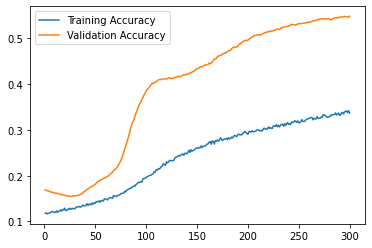

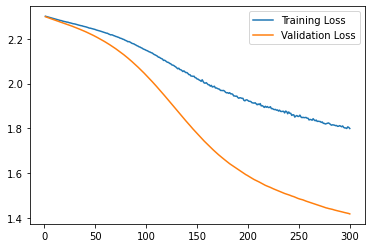

In [37]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(("Training Accuracy", "Validation Accuracy"))
plt.show()

plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(("Training Loss", "Validation Loss"))
plt.show()

## Visualization of Performance on the Test Set

Here is a visualization of how well our classifier can do inference.

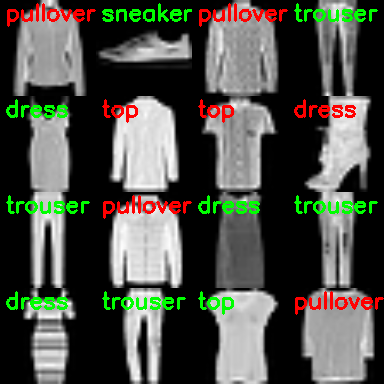

-1

In [38]:
import cv2
from imutils import build_montages
from google.colab.patches import cv2_imshow

# initialize our list of output images
images = []

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = model.predict(x_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (x_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (x_test[i] * 255).astype("uint8")
    # initialize the text label color as green (correct)
	color = (0, 255, 0)
 
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
 
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
 
# show the output montage
cv2_imshow( montage)
cv2.waitKey(0)

Text(0.5, 1.0, 'True vs Predicted Labels')

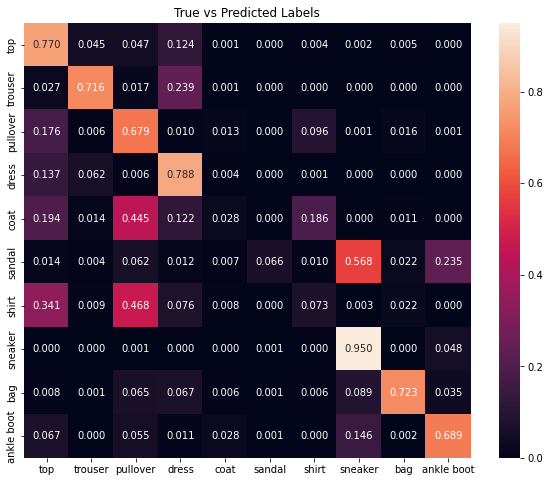

In [58]:
from seaborn import heatmap
allprobs = model.predict(x_test)
preds = allprobs.argmax(axis=1)
conmat = confusion_matrix(y_dec,preds,normalize='true')
fig,ax = plt.subplots(figsize = (10,8));
heatmap(conmat, annot=True, fmt="0.3f", ax=ax);
ax.set_xticklabels(labelNames);
ax.set_yticklabels(labelNames);
ax.set_title("True vs Predicted Labels");